# Evaluation of TSP Solvers

In [1]:
!pip install python_tsp
!pip install fast-tsp

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## Import Relevant Libraries

In [2]:
from gettext import install

import sys
import os
import time

import numpy as np
import pandas as pd

# Import from matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Import from scipy
from scipy.spatial import distance_matrix
# from scipy.optimize import linprog

# Import from python-tsp
from python_tsp.exact import solve_tsp_dynamic_programming as dynamic_programming

## Testing using a randomly generated distance matrix

### Creating the matrix

In [3]:
def generate_random_points(n, seed=None):
    np.random.seed(seed)
    return np.random.rand(n, 2)*1000

In [4]:
test = generate_random_points(10, seed=42)
print(test)

[[374.54011885 950.71430641]
 [731.99394181 598.6584842 ]
 [156.01864044 155.99452034]
 [ 58.08361217 866.17614577]
 [601.11501174 708.0725778 ]
 [ 20.5844943  969.90985216]
 [832.4426408  212.33911068]
 [181.82496721 183.40450985]
 [304.24224296 524.75643163]
 [431.94501864 291.2291402 ]]


In [5]:
def generate_distance_matrix(points):
    return distance_matrix(points, points)

In [6]:
dist = generate_distance_matrix(test)
print(dist)

[[   0.          501.71360108  824.21549057  327.55369212  331.98070811
   354.47574406  868.83407466  791.1406029   431.71970356  661.97885689]
 [ 501.71360108    0.          726.42889032  725.06608779  170.58938482
   802.45310158  399.16487757  689.29076871  434.0887343   429.58370296]
 [ 824.21549057  726.42889032    0.          716.90251142  709.15510382
   825.10640243  678.7666323    37.64670007  397.43626353  307.28450757]
 [ 327.55369212  725.06608779  716.90251142    0.          565.57920677
   110.30351618 1013.47657777  693.89410559  420.90556271  685.81076871]
 [ 331.98070811  170.58938482  709.15510382  565.57920677    0.
   636.84726578  547.05040205  671.62543353  348.91008912  449.8632437 ]
 [ 354.47574406  802.45310158  825.10640243  110.30351618  636.84726578
     0.         1110.41752436  802.86309143  527.84778695  793.61513959]
 [ 868.83407466  399.16487757  678.7666323  1013.47657777  547.05040205
  1110.41752436    0.          651.26075294  613.67763745  408.193

### Using Dynamic Programming

In [7]:
def dynamic_prog(dist):
    result = dynamic_programming(dist)

    # Return back to depot
    result[0].append(0)
    return result

result = dynamic_prog(dist)
print(result[0], result[1])

[0, 4, 1, 6, 9, 7, 2, 8, 3, 5, 0] 2903.067737777875


### Using Christofides

In [8]:
class UnionFind:
    def __init__(self):
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root

    def __iter__(self):
        return iter(self.parents)

    def union(self, *objects):
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r], r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest


def minimum_spanning_tree(G):
    tree = []
    subtrees = UnionFind()
    for W, u, v in sorted((G[u][v], u, v) for u in G for v in G[u]):
        if subtrees[u] != subtrees[v]:
            tree.append((u, v, W))
            subtrees.union(u, v)
    return tree


def find_odd_vertexes(MST):
    tmp_g = {}
    vertexes = []
    for edge in MST:
        if edge[0] not in tmp_g:
            tmp_g[edge[0]] = 0

        if edge[1] not in tmp_g:
            tmp_g[edge[1]] = 0

        tmp_g[edge[0]] += 1
        tmp_g[edge[1]] += 1

    for vertex in tmp_g:
        if tmp_g[vertex] % 2 == 1:
            vertexes.append(vertex)

    return vertexes


def minimum_weight_matching(MST, G, odd_vert):
    import random
    random.shuffle(odd_vert)

    while odd_vert:
        v = odd_vert.pop()
        length = float("inf")
        u = 1
        closest = 0
        for u in odd_vert:
            if v != u and G[v][u] < length:
                length = G[v][u]
                closest = u

        MST.append((v, closest, length))
        odd_vert.remove(closest)


def find_eulerian_tour(MatchedMSTree, G):
    # find neigbours
    neighbours = {}
    for edge in MatchedMSTree:
        if edge[0] not in neighbours:
            neighbours[edge[0]] = []

        if edge[1] not in neighbours:
            neighbours[edge[1]] = []

        neighbours[edge[0]].append(edge[1])
        neighbours[edge[1]].append(edge[0])

    # print("Neighbours: ", neighbours)

    # finds the hamiltonian circuit
    start_vertex = MatchedMSTree[0][0]
    EP = [neighbours[start_vertex][0]]

    while len(MatchedMSTree) > 0:
        for i, v in enumerate(EP):
            if len(neighbours[v]) > 0:
                break

        while len(neighbours[v]) > 0:
            w = neighbours[v][0]

            remove_edge_from_matchedMST(MatchedMSTree, v, w)

            del neighbours[v][(neighbours[v].index(w))]
            del neighbours[w][(neighbours[w].index(v))]

            i += 1
            EP.insert(i, w)

            v = w

    return EP


def remove_edge_from_matchedMST(MatchedMST, v1, v2):
    for i, item in enumerate(MatchedMST):
        if (item[0] == v2 and item[1] == v1) or (item[0] == v1 and item[1] == v2):
            del MatchedMST[i]

    return MatchedMST

In [9]:
# https://github.com/Retsediv/ChristofidesAlgorithm
from collections import defaultdict

def christofides(dist):
    # build a graph
    G = defaultdict(dict)
    # print("Graph: ", G)

    for i in range(len(dist)):
        for j in range(len(dist[i])):
            if i != j:
                G[i][j] = dist[i][j]

    # build a minimum spanning tree
    MSTree = minimum_spanning_tree(G)
    # print("MSTree: ", MSTree)

    # find odd vertexes
    odd_vertexes = find_odd_vertexes(MSTree)
    # print("Odd vertexes in MSTree: ", odd_vertexes)

    # add minimum weight matching edges to MST
    minimum_weight_matching(MSTree, G, odd_vertexes)
    # print("Minimum weight matching: ", MSTree)

    # find an eulerian tour
    eulerian_tour = find_eulerian_tour(MSTree, G)

    # print("Eulerian tour: ", eulerian_tour)

    current = eulerian_tour[0]
    path = [current]
    visited = [False] * len(eulerian_tour)
    visited[eulerian_tour[0]] = True
    length = 0
    
    for v in eulerian_tour:
        if not visited[v]:
            path.append(v)
            visited[v] = True

            length += G[current][v]
            current = v

    length +=G[current][eulerian_tour[0]]
    path.append(eulerian_tour[0])

    # print("Result path: ", path)
    # print("Result length of the path: ", length)

    return path, length

### Using Greedy

In [10]:
import fast_tsp

def greedy(dist):
    pairwise_dist = (dist * 1000).astype(int)
    tour = fast_tsp.greedy_nearest_neighbor(pairwise_dist)

    # Need to return back to depot
    tour.append(0)
    
    total_dist = 0
    for i in range(len(tour)-1):
        total_dist += dist[tour[i], tour[i+1]]
    return tour, total_dist

### Using OR-Tools

In [11]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

class ORTools:
    def __init__(self, dist_matrix):
        self.dist_matrix = dist_matrix
        self.manager = pywrapcp.RoutingIndexManager(len(self.dist_matrix), 1, 0)
        self.routing = pywrapcp.RoutingModel(self.manager)
        self.solution = self.solve()

    def distance_callback(self, from_index, to_index):
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = self.manager.IndexToNode(from_index)
        to_node = self.manager.IndexToNode(to_index)
        distance_matrix = self.dist_matrix.astype(int)

        return distance_matrix[from_node][to_node]
    
    def solve(self):
        transit_callback_index = self.routing.RegisterTransitCallback(self.distance_callback)
        self.routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        self.search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        self.search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
        solution = self.routing.SolveWithParameters(self.search_parameters)
        return solution
        
    def print_solution(self):
        index = self.routing.Start(0)
        # plan_output = "Route for vehicle 0:\n"
        route_distance = 0
        route = []

        while not self.routing.IsEnd(index):
            # plan_output += f" {self.manager.IndexToNode(index)} ->"
            route.append(self.manager.IndexToNode(index))
            previous_index = index
            index = self.solution.Value(self.routing.NextVar(index))
            # route_distance += self.routing.GetArcCostForVehicle(previous_index, index, 0)
            # print(previous_index, index)
            if index == len(self.dist_matrix):
                route_distance += self.dist_matrix[self.manager.IndexToNode(previous_index), self.manager.IndexToNode(0)]
            else:
                route_distance += self.dist_matrix[self.manager.IndexToNode(previous_index), self.manager.IndexToNode(index)]

        # Return back to depot
        route.append(self.manager.IndexToNode(0))
        
        # plan_output += f" {self.manager.IndexToNode(index)}\n"
        # plan_output += f"Route distance: {route_distance}\n"
        # print(plan_output)
        
        # print(route_distance)
        return route, route_distance
        

In [12]:
def or_tools(distance_matrix):
    # Create the routing index manager.
    ortool = ORTools(distance_matrix)
    return ortool.print_solution()

### Final Output

In [13]:
def evaluate(solvers, distance_matrix, instance_name=None, num_dests=None):
    # Input arguments: 
    # solvers - dict(name: str, solver: function)
    # distance_matrix - n-by-n matrix containing pairwise distances
    # instance_name - name of the instance
    # num_dests - number of destinations to visit

    if num_dests is None:
        num_dests = len(distance_matrix) - 1

    results = {}
    for name, solver in solvers.items():
        start = time.time_ns()
        result = solver(distance_matrix)
        end = time.time_ns()

        results[name] = {
            'instance': instance_name,
            'sequence': result[0],
            'distance (m)': result[1],
            'time (ns)': end - start,
            'num_dests': num_dests
        }

    # print(results)
    # result = {"name_of_solver": {"result": order of seq,
    #                              "distance": distance travelled.
    #                              "time": time taken to find a solution}}
    return results


def plot_points(points, tour=None):
    plt.scatter(points[:, 0], points[:, 1])
    if tour is not None:
        for i in range(len(tour)):
            plt.plot([points[tour[i-1], 0], points[tour[i], 0]], [points[tour[i-1], 1], points[tour[i], 1]], 'r-')
    plt.show()


def plot_results(points, results, distance_matrix):
    plot_points(points)
    
    print(results)

    for name, result in results.items():
        tour = result['sequence']
        if tour is not None:
            plot_points(points, tour)
            print(f'{name} - Length: {sum(distance_matrix[tour[i], tour[i+1]] for i in range(len(tour) - 1))}')

        else:
            print(f'{name} - No solution found')
        print(f'{name} - Time: {result["time (ns)"]} ns\n')

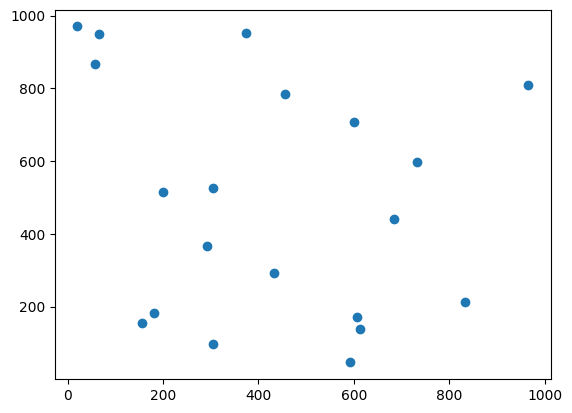

{'Greedy': {'instance': None, 'sequence': [0, 12, 4, 1, 19, 6, 15, 10, 14, 18, 7, 2, 11, 9, 8, 13, 3, 16, 5, 17, 0], 'distance (m)': 4650.384155596448, 'time (ns)': 0, 'num_dests': 19}, 'Christofides': {'instance': None, 'sequence': [15, 10, 14, 9, 11, 7, 2, 18, 8, 13, 3, 16, 5, 0, 12, 4, 1, 17, 19, 6, 15], 'distance (m)': 4184.241873325269, 'time (ns)': 0, 'num_dests': 19}, 'OR Tools': {'instance': None, 'sequence': [0, 16, 5, 3, 13, 8, 11, 9, 7, 2, 18, 14, 10, 15, 6, 19, 1, 17, 4, 12, 0], 'distance (m)': 3866.266770061002, 'time (ns)': 9536500, 'num_dests': 19}, 'Dynamic Programming': {'instance': None, 'sequence': [0, 16, 5, 3, 13, 8, 11, 7, 2, 18, 9, 15, 10, 14, 6, 19, 1, 17, 4, 12, 0], 'distance (m)': 3864.296894765133, 'time (ns)': 39148486100, 'num_dests': 19}}


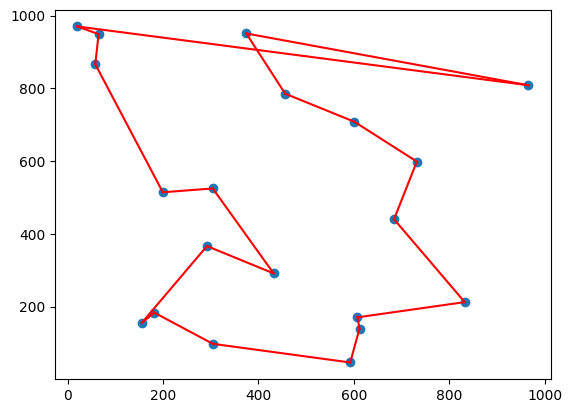

Greedy - Length: 4650.384155596448
Greedy - Time: 0 ns



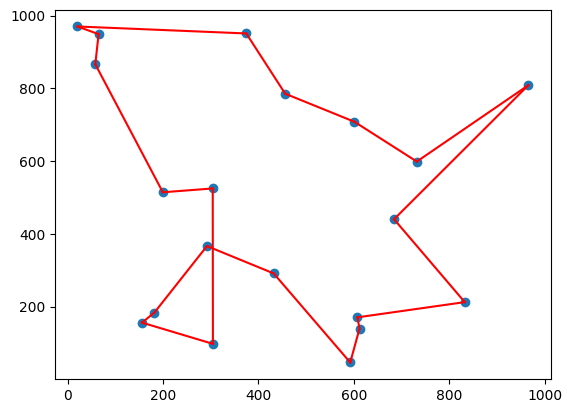

Christofides - Length: 4184.241873325269
Christofides - Time: 0 ns



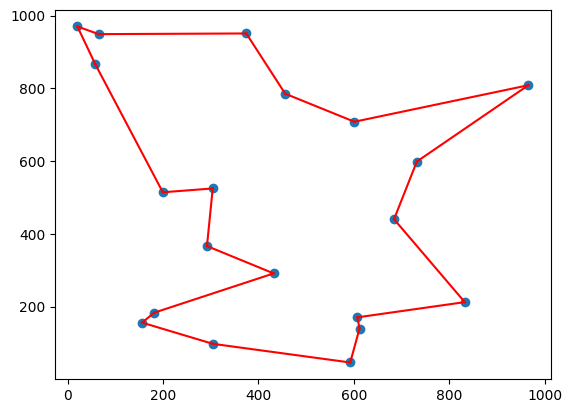

OR Tools - Length: 3866.266770061002
OR Tools - Time: 9536500 ns



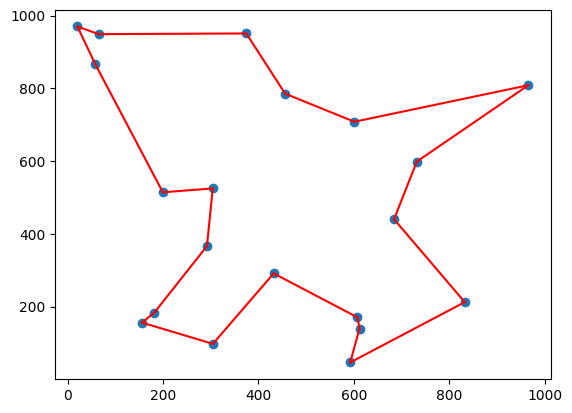

Dynamic Programming - Length: 3864.2968947651334
Dynamic Programming - Time: 39148486100 ns



In [14]:
def main():
    n = 20
    seed = 42
    sample_points = generate_random_points(n, seed)
    distance_matrix = generate_distance_matrix(sample_points)

    solvers = {
        'Greedy': greedy,
        'Christofides': christofides,
        'OR Tools': or_tools,
        'Dynamic Programming': dynamic_prog,
    }

    results = evaluate(solvers, distance_matrix)

    plot_results(sample_points, results, distance_matrix)

main()

## Executing Solvers on all Problem Instances

In [15]:
from pathlib import Path
import glob
from tqdm import tqdm

In [16]:
res = glob.glob("../processed_heuristic-threshold/instances/1/*/*")
print(res)

['../processed_heuristic-threshold/instances/1\\1\\ds_1002_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1002_courier_967', '../processed_heuristic-threshold/instances/1\\1\\ds_1003_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1005_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1007_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1007_courier_3030', '../processed_heuristic-threshold/instances/1\\1\\ds_1008_courier_967', '../processed_heuristic-threshold/instances/1\\1\\ds_1014_courier_3030', '../processed_heuristic-threshold/instances/1\\1\\ds_1015_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1019_courier_1520', '../processed_heuristic-threshold/instances/1\\1\\ds_1020_courier_1558', '../processed_heuristic-threshold/instances/1\\1\\ds_1021_courier_3030', '../processed_heuristic-threshold/instances/1\\1\\ds_1021_courier_87', '../processed_heuristic-threshold/instances/1\\1\\ds_1022_c

In [17]:
def run_solvers(file_path, solvers):
    path = Path(file_path)
    print(path)
    
    result = None
    if path.is_dir():
    
        with np.load(path / 'pairwise.npz') as data:
            dist_matrix = data["arr_0"]

        num_dest = dist_matrix.shape[0] - 1

        result = evaluate(solvers, dist_matrix, path.name, num_dests=num_dest)
        print(result, end="\n\n")

    return result

In [18]:
def generate_solver_df(file_paths):
    solvers = {
    'Greedy': greedy,
    'Christofides': christofides,
    'OR Tools': or_tools,
    # 'Dynamic Programming': dynamic_prog,
    }

    greedy_results = []
    christofides_results = []
    or_tools_results = []
    dynamic_prog_results = []

    for path in tqdm(file_paths):
        result = run_solvers(path, solvers)
        print(result)
        
        for key, value in result.items():
            if key == "Greedy":
                greedy_results.append(value)
            elif key == "Christofides":
                christofides_results.append(value)
            elif key == "OR Tools":
                or_tools_results.append(value)
            elif key == "Dynamic Programming":
                dynamic_prog_results.append(value)
    
    greedy_df = pd.DataFrame(greedy_results)
    christofides_df = pd.DataFrame(christofides_results)
    or_tools_df = pd.DataFrame(or_tools_results)
    dynamic_prog_df = pd.DataFrame(dynamic_prog_results)

    greedy_df.to_csv("greedy_results.csv", index=False)
    christofides_df.to_csv("christofides_results.csv", index=False)
    or_tools_df.to_csv("or_tools_results.csv", index=False)
    dynamic_prog_df.to_csv("dynamic_prog_results.csv", index=False)

    return greedy_df, christofides_df, or_tools_df, dynamic_prog_df
    

In [19]:
generate_solver_df(res)

  0%|          | 0/1492 [00:00<?, ?it/s]

..\processed_heuristic-threshold\instances\1\1\ds_1002_courier_218
{'Greedy': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}, 'Christofides': {'instance': 'ds_1002_courier_218', 'sequence': [1, 0, 1], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}, 'OR Tools': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}}

{'Greedy': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}, 'Christofides': {'instance': 'ds_1002_courier_218', 'sequence': [1, 0, 1], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}, 'OR Tools': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}}
..\processed_heuristic-threshold\instances\1\1\ds_1002_courier_967
{'Greedy': {'instance': '

  7%|▋         | 104/1492 [00:00<00:01, 1031.04it/s]

{'Greedy': {'instance': 'ds_608_courier_161', 'sequence': [0, 1, 0], 'distance (m)': 10353.249476845302, 'time (ns)': 0, 'num_dests': 1}, 'Christofides': {'instance': 'ds_608_courier_161', 'sequence': [1, 0, 1], 'distance (m)': 10353.249476845302, 'time (ns)': 0, 'num_dests': 1}, 'OR Tools': {'instance': 'ds_608_courier_161', 'sequence': [0, 1, 0], 'distance (m)': 10353.249476845302, 'time (ns)': 0, 'num_dests': 1}}

{'Greedy': {'instance': 'ds_608_courier_161', 'sequence': [0, 1, 0], 'distance (m)': 10353.249476845302, 'time (ns)': 0, 'num_dests': 1}, 'Christofides': {'instance': 'ds_608_courier_161', 'sequence': [1, 0, 1], 'distance (m)': 10353.249476845302, 'time (ns)': 0, 'num_dests': 1}, 'OR Tools': {'instance': 'ds_608_courier_161', 'sequence': [0, 1, 0], 'distance (m)': 10353.249476845302, 'time (ns)': 0, 'num_dests': 1}}
..\processed_heuristic-threshold\instances\1\1\ds_608_courier_2709
{'Greedy': {'instance': 'ds_608_courier_2709', 'sequence': [0, 1, 0], 'distance (m)': 4851.7

 14%|█▍        | 208/1492 [00:00<00:02, 620.50it/s] 

..\processed_heuristic-threshold\instances\1\11\ds_611_courier_1656
{'Greedy': {'instance': 'ds_611_courier_1656', 'sequence': [0, 9, 10, 2, 8, 4, 7, 5, 1, 3, 6, 11, 0], 'distance (m)': 21152.372735482524, 'time (ns)': 0, 'num_dests': 11}, 'Christofides': {'instance': 'ds_611_courier_1656', 'sequence': [7, 5, 1, 3, 10, 9, 0, 11, 2, 8, 4, 6, 7], 'distance (m)': 20501.890007005615, 'time (ns)': 0, 'num_dests': 11}, 'OR Tools': {'instance': 'ds_611_courier_1656', 'sequence': [0, 2, 8, 4, 6, 1, 7, 5, 3, 10, 9, 11, 0], 'distance (m)': 18557.82143426824, 'time (ns)': 3000000, 'num_dests': 11}}

{'Greedy': {'instance': 'ds_611_courier_1656', 'sequence': [0, 9, 10, 2, 8, 4, 7, 5, 1, 3, 6, 11, 0], 'distance (m)': 21152.372735482524, 'time (ns)': 0, 'num_dests': 11}, 'Christofides': {'instance': 'ds_611_courier_1656', 'sequence': [7, 5, 1, 3, 10, 9, 0, 11, 2, 8, 4, 6, 7], 'distance (m)': 20501.890007005615, 'time (ns)': 0, 'num_dests': 11}, 'OR Tools': {'instance': 'ds_611_courier_1656', 'sequen

 19%|█▊        | 279/1492 [00:00<00:02, 478.88it/s]

{'Greedy': {'instance': 'ds_705_courier_638', 'sequence': [0, 6, 5, 12, 7, 11, 10, 8, 9, 2, 3, 4, 1, 0], 'distance (m)': 6136.776888134265, 'time (ns)': 0, 'num_dests': 12}, 'Christofides': {'instance': 'ds_705_courier_638', 'sequence': [12, 5, 6, 0, 11, 10, 9, 1, 4, 2, 3, 8, 7, 12], 'distance (m)': 7150.190531042544, 'time (ns)': 0, 'num_dests': 12}, 'OR Tools': {'instance': 'ds_705_courier_638', 'sequence': [0, 6, 5, 12, 7, 9, 10, 11, 8, 2, 4, 1, 3, 0], 'distance (m)': 5636.196100350897, 'time (ns)': 4031100, 'num_dests': 12}}

{'Greedy': {'instance': 'ds_705_courier_638', 'sequence': [0, 6, 5, 12, 7, 11, 10, 8, 9, 2, 3, 4, 1, 0], 'distance (m)': 6136.776888134265, 'time (ns)': 0, 'num_dests': 12}, 'Christofides': {'instance': 'ds_705_courier_638', 'sequence': [12, 5, 6, 0, 11, 10, 9, 1, 4, 2, 3, 8, 7, 12], 'distance (m)': 7150.190531042544, 'time (ns)': 0, 'num_dests': 12}, 'OR Tools': {'instance': 'ds_705_courier_638', 'sequence': [0, 6, 5, 12, 7, 9, 10, 11, 8, 2, 4, 1, 3, 0], 'dis

 22%|██▏       | 334/1492 [00:00<00:02, 416.19it/s]

..\processed_heuristic-threshold\instances\1\13\ds_725_courier_4474
{'Greedy': {'instance': 'ds_725_courier_4474', 'sequence': [0, 6, 3, 7, 2, 8, 9, 10, 4, 13, 5, 1, 11, 12, 0], 'distance (m)': 6084.187495074788, 'time (ns)': 0, 'num_dests': 13}, 'Christofides': {'instance': 'ds_725_courier_4474', 'sequence': [13, 4, 10, 9, 8, 2, 7, 3, 6, 0, 12, 11, 1, 5, 13], 'distance (m)': 6084.187495074789, 'time (ns)': 995000, 'num_dests': 13}, 'OR Tools': {'instance': 'ds_725_courier_4474', 'sequence': [0, 6, 3, 7, 2, 8, 9, 10, 4, 13, 5, 1, 11, 12, 0], 'distance (m)': 6084.187495074788, 'time (ns)': 1999400, 'num_dests': 13}}

{'Greedy': {'instance': 'ds_725_courier_4474', 'sequence': [0, 6, 3, 7, 2, 8, 9, 10, 4, 13, 5, 1, 11, 12, 0], 'distance (m)': 6084.187495074788, 'time (ns)': 0, 'num_dests': 13}, 'Christofides': {'instance': 'ds_725_courier_4474', 'sequence': [13, 4, 10, 9, 8, 2, 7, 3, 6, 0, 12, 11, 1, 5, 13], 'distance (m)': 6084.187495074789, 'time (ns)': 995000, 'num_dests': 13}, 'OR Too

 25%|██▌       | 380/1492 [00:00<00:03, 370.14it/s]

{'Greedy': {'instance': 'ds_618_courier_4474', 'sequence': [0, 3, 1, 2, 5, 4, 9, 7, 6, 8, 11, 14, 12, 13, 10, 0], 'distance (m)': 7509.195489922777, 'time (ns)': 0, 'num_dests': 14}, 'Christofides': {'instance': 'ds_618_courier_4474', 'sequence': [14, 12, 13, 10, 0, 3, 1, 2, 5, 6, 4, 9, 7, 8, 11, 14], 'distance (m)': 6966.690467369757, 'time (ns)': 999800, 'num_dests': 14}, 'OR Tools': {'instance': 'ds_618_courier_4474', 'sequence': [0, 3, 1, 4, 6, 5, 2, 9, 7, 8, 11, 14, 12, 13, 10, 0], 'distance (m)': 6892.387307731362, 'time (ns)': 3000800, 'num_dests': 14}}

{'Greedy': {'instance': 'ds_618_courier_4474', 'sequence': [0, 3, 1, 2, 5, 4, 9, 7, 6, 8, 11, 14, 12, 13, 10, 0], 'distance (m)': 7509.195489922777, 'time (ns)': 0, 'num_dests': 14}, 'Christofides': {'instance': 'ds_618_courier_4474', 'sequence': [14, 12, 13, 10, 0, 3, 1, 2, 5, 6, 4, 9, 7, 8, 11, 14], 'distance (m)': 6966.690467369757, 'time (ns)': 999800, 'num_dests': 14}, 'OR Tools': {'instance': 'ds_618_courier_4474', 'sequen

 28%|██▊       | 420/1492 [00:01<00:03, 329.40it/s]

..\processed_heuristic-threshold\instances\1\15\ds_715_courier_4474
{'Greedy': {'instance': 'ds_715_courier_4474', 'sequence': [0, 7, 11, 8, 9, 6, 12, 4, 1, 5, 10, 3, 14, 13, 2, 15, 0], 'distance (m)': 9077.959146507737, 'time (ns)': 0, 'num_dests': 15}, 'Christofides': {'instance': 'ds_715_courier_4474', 'sequence': [10, 3, 14, 13, 6, 12, 4, 2, 15, 0, 7, 11, 8, 9, 1, 5, 10], 'distance (m)': 8993.838799387317, 'time (ns)': 1003600, 'num_dests': 15}, 'OR Tools': {'instance': 'ds_715_courier_4474', 'sequence': [0, 7, 9, 8, 11, 6, 13, 14, 10, 3, 5, 12, 4, 1, 2, 15, 0], 'distance (m)': 8126.736732518296, 'time (ns)': 3502000, 'num_dests': 15}}

{'Greedy': {'instance': 'ds_715_courier_4474', 'sequence': [0, 7, 11, 8, 9, 6, 12, 4, 1, 5, 10, 3, 14, 13, 2, 15, 0], 'distance (m)': 9077.959146507737, 'time (ns)': 0, 'num_dests': 15}, 'Christofides': {'instance': 'ds_715_courier_4474', 'sequence': [10, 3, 14, 13, 6, 12, 4, 2, 15, 0, 7, 11, 8, 9, 1, 5, 10], 'distance (m)': 8993.838799387317, 'time

 30%|███       | 455/1492 [00:01<00:03, 294.34it/s]

{'Greedy': {'instance': 'ds_906_courier_487', 'sequence': [0, 12, 13, 14, 5, 4, 3, 2, 15, 7, 6, 8, 1, 10, 9, 11, 0], 'distance (m)': 15051.290757177168, 'time (ns)': 0, 'num_dests': 15}, 'Christofides': {'instance': 'ds_906_courier_487', 'sequence': [3, 2, 15, 12, 7, 6, 8, 1, 10, 9, 11, 0, 13, 14, 5, 4, 3], 'distance (m)': 15939.191605285989, 'time (ns)': 1000800, 'num_dests': 15}, 'OR Tools': {'instance': 'ds_906_courier_487', 'sequence': [0, 12, 13, 14, 5, 15, 2, 3, 4, 7, 6, 8, 1, 10, 9, 11, 0], 'distance (m)': 14955.106306796686, 'time (ns)': 2998200, 'num_dests': 15}}

{'Greedy': {'instance': 'ds_906_courier_487', 'sequence': [0, 12, 13, 14, 5, 4, 3, 2, 15, 7, 6, 8, 1, 10, 9, 11, 0], 'distance (m)': 15051.290757177168, 'time (ns)': 0, 'num_dests': 15}, 'Christofides': {'instance': 'ds_906_courier_487', 'sequence': [3, 2, 15, 12, 7, 6, 8, 1, 10, 9, 11, 0, 13, 14, 5, 4, 3], 'distance (m)': 15939.191605285989, 'time (ns)': 1000800, 'num_dests': 15}, 'OR Tools': {'instance': 'ds_906_co

 33%|███▎      | 486/1492 [00:01<00:03, 269.67it/s]

{'Greedy': {'instance': 'ds_801_courier_638', 'sequence': [0, 15, 8, 7, 6, 10, 9, 11, 2, 1, 5, 4, 12, 3, 14, 13, 16, 0], 'distance (m)': 5663.345363054159, 'time (ns)': 0, 'num_dests': 16}, 'Christofides': {'instance': 'ds_801_courier_638', 'sequence': [7, 6, 10, 9, 11, 2, 1, 0, 15, 8, 5, 4, 12, 3, 16, 13, 14, 7], 'distance (m)': 6005.252658649113, 'time (ns)': 0, 'num_dests': 16}, 'OR Tools': {'instance': 'ds_801_courier_638', 'sequence': [0, 15, 8, 16, 13, 14, 3, 12, 4, 5, 11, 2, 1, 9, 10, 6, 7, 0], 'distance (m)': 5497.8448118923425, 'time (ns)': 5044600, 'num_dests': 16}}

{'Greedy': {'instance': 'ds_801_courier_638', 'sequence': [0, 15, 8, 7, 6, 10, 9, 11, 2, 1, 5, 4, 12, 3, 14, 13, 16, 0], 'distance (m)': 5663.345363054159, 'time (ns)': 0, 'num_dests': 16}, 'Christofides': {'instance': 'ds_801_courier_638', 'sequence': [7, 6, 10, 9, 11, 2, 1, 0, 15, 8, 5, 4, 12, 3, 16, 13, 14, 7], 'distance (m)': 6005.252658649113, 'time (ns)': 0, 'num_dests': 16}, 'OR Tools': {'instance': 'ds_80

 34%|███▍      | 514/1492 [00:01<00:03, 248.32it/s]

{'Greedy': {'instance': 'ds_705_courier_2925', 'sequence': [0, 13, 7, 4, 3, 5, 15, 17, 8, 10, 14, 11, 2, 16, 1, 6, 12, 9, 0], 'distance (m)': 11147.836611762637, 'time (ns)': 0, 'num_dests': 17}, 'Christofides': {'instance': 'ds_705_courier_2925', 'sequence': [17, 15, 5, 8, 10, 14, 9, 2, 16, 1, 6, 12, 11, 3, 4, 7, 13, 0, 17], 'distance (m)': 11154.755646176462, 'time (ns)': 0, 'num_dests': 17}, 'OR Tools': {'instance': 'ds_705_courier_2925', 'sequence': [0, 13, 7, 4, 17, 15, 5, 9, 2, 16, 6, 12, 1, 11, 14, 10, 8, 3, 0], 'distance (m)': 10767.761161578084, 'time (ns)': 7998400, 'num_dests': 17}}

{'Greedy': {'instance': 'ds_705_courier_2925', 'sequence': [0, 13, 7, 4, 3, 5, 15, 17, 8, 10, 14, 11, 2, 16, 1, 6, 12, 9, 0], 'distance (m)': 11147.836611762637, 'time (ns)': 0, 'num_dests': 17}, 'Christofides': {'instance': 'ds_705_courier_2925', 'sequence': [17, 15, 5, 8, 10, 14, 9, 2, 16, 1, 6, 12, 11, 3, 4, 7, 13, 0, 17], 'distance (m)': 11154.755646176462, 'time (ns)': 0, 'num_dests': 17}, 

 36%|███▌      | 539/1492 [00:01<00:04, 231.07it/s]

{'Greedy': {'instance': 'ds_808_courier_435', 'sequence': [0, 1, 14, 8, 7, 6, 17, 16, 5, 15, 10, 13, 11, 9, 3, 12, 4, 2, 0], 'distance (m)': 7338.630898188025, 'time (ns)': 0, 'num_dests': 17}, 'Christofides': {'instance': 'ds_808_courier_435', 'sequence': [1, 0, 14, 8, 7, 6, 17, 16, 5, 15, 11, 9, 3, 12, 2, 4, 13, 10, 1], 'distance (m)': 7304.247107164057, 'time (ns)': 0, 'num_dests': 17}, 'OR Tools': {'instance': 'ds_808_courier_435', 'sequence': [0, 1, 10, 13, 11, 9, 4, 3, 12, 2, 16, 5, 15, 17, 6, 7, 8, 14, 0], 'distance (m)': 6110.83124954658, 'time (ns)': 5540700, 'num_dests': 17}}

{'Greedy': {'instance': 'ds_808_courier_435', 'sequence': [0, 1, 14, 8, 7, 6, 17, 16, 5, 15, 10, 13, 11, 9, 3, 12, 4, 2, 0], 'distance (m)': 7338.630898188025, 'time (ns)': 0, 'num_dests': 17}, 'Christofides': {'instance': 'ds_808_courier_435', 'sequence': [1, 0, 14, 8, 7, 6, 17, 16, 5, 15, 11, 9, 3, 12, 2, 4, 13, 10, 1], 'distance (m)': 7304.247107164057, 'time (ns)': 0, 'num_dests': 17}, 'OR Tools': {

 38%|███▊      | 562/1492 [00:01<00:04, 209.42it/s]

{'Greedy': {'instance': 'ds_703_courier_2925', 'sequence': [0, 11, 17, 10, 18, 15, 8, 14, 3, 4, 9, 12, 13, 2, 7, 16, 1, 6, 5, 0], 'distance (m)': 11536.799517160642, 'time (ns)': 0, 'num_dests': 18}, 'Christofides': {'instance': 'ds_703_courier_2925', 'sequence': [9, 4, 3, 14, 8, 15, 5, 18, 10, 17, 11, 0, 1, 16, 7, 2, 13, 6, 12, 9], 'distance (m)': 12207.187293182948, 'time (ns)': 0, 'num_dests': 18}, 'OR Tools': {'instance': 'ds_703_courier_2925', 'sequence': [0, 11, 17, 5, 12, 13, 2, 7, 16, 1, 6, 9, 4, 3, 14, 8, 15, 18, 10, 0], 'distance (m)': 11348.90978215871, 'time (ns)': 5477800, 'num_dests': 18}}

{'Greedy': {'instance': 'ds_703_courier_2925', 'sequence': [0, 11, 17, 10, 18, 15, 8, 14, 3, 4, 9, 12, 13, 2, 7, 16, 1, 6, 5, 0], 'distance (m)': 11536.799517160642, 'time (ns)': 0, 'num_dests': 18}, 'Christofides': {'instance': 'ds_703_courier_2925', 'sequence': [9, 4, 3, 14, 8, 15, 5, 18, 10, 17, 11, 0, 1, 16, 7, 2, 13, 6, 12, 9], 'distance (m)': 12207.187293182948, 'time (ns)': 0, '

 39%|███▉      | 583/1492 [00:01<00:04, 199.47it/s]

{'Greedy': {'instance': 'ds_908_courier_4474', 'sequence': [0, 15, 3, 2, 1, 16, 11, 17, 14, 13, 18, 12, 7, 8, 9, 6, 4, 10, 5, 0], 'distance (m)': 8800.916178032738, 'time (ns)': 0, 'num_dests': 18}, 'Christofides': {'instance': 'ds_908_courier_4474', 'sequence': [14, 13, 18, 12, 11, 16, 2, 1, 8, 9, 7, 6, 4, 5, 10, 0, 15, 3, 17, 14], 'distance (m)': 9407.838389111432, 'time (ns)': 0, 'num_dests': 18}, 'OR Tools': {'instance': 'ds_908_courier_4474', 'sequence': [0, 15, 3, 1, 2, 16, 18, 13, 14, 17, 11, 12, 10, 5, 4, 6, 7, 8, 9, 0], 'distance (m)': 7886.117023623464, 'time (ns)': 6522300, 'num_dests': 18}}

{'Greedy': {'instance': 'ds_908_courier_4474', 'sequence': [0, 15, 3, 2, 1, 16, 11, 17, 14, 13, 18, 12, 7, 8, 9, 6, 4, 10, 5, 0], 'distance (m)': 8800.916178032738, 'time (ns)': 0, 'num_dests': 18}, 'Christofides': {'instance': 'ds_908_courier_4474', 'sequence': [14, 13, 18, 12, 11, 16, 2, 1, 8, 9, 7, 6, 4, 5, 10, 0, 15, 3, 17, 14], 'distance (m)': 9407.838389111432, 'time (ns)': 0, 'nu

 40%|████      | 603/1492 [00:02<00:04, 180.50it/s]

{'Greedy': {'instance': 'ds_529_courier_2289', 'sequence': [0, 5, 14, 10, 6, 4, 3, 7, 19, 12, 1, 13, 11, 2, 9, 8, 17, 16, 15, 18, 0], 'distance (m)': 196400.18492492026, 'time (ns)': 0, 'num_dests': 19}, 'Christofides': {'instance': 'ds_529_courier_2289', 'sequence': [4, 3, 7, 19, 12, 1, 13, 11, 2, 9, 8, 10, 14, 15, 5, 0, 18, 16, 17, 6, 4], 'distance (m)': 196679.6368408163, 'time (ns)': 1000000, 'num_dests': 19}, 'OR Tools': {'instance': 'ds_529_courier_2289', 'sequence': [0, 5, 14, 8, 9, 2, 11, 13, 1, 12, 19, 7, 3, 4, 6, 10, 17, 16, 15, 18, 0], 'distance (m)': 196365.67873575215, 'time (ns)': 4000200, 'num_dests': 19}}

{'Greedy': {'instance': 'ds_529_courier_2289', 'sequence': [0, 5, 14, 10, 6, 4, 3, 7, 19, 12, 1, 13, 11, 2, 9, 8, 17, 16, 15, 18, 0], 'distance (m)': 196400.18492492026, 'time (ns)': 0, 'num_dests': 19}, 'Christofides': {'instance': 'ds_529_courier_2289', 'sequence': [4, 3, 7, 19, 12, 1, 13, 11, 2, 9, 8, 10, 14, 15, 5, 0, 18, 16, 17, 6, 4], 'distance (m)': 196679.6368

 42%|████▏     | 621/1492 [00:02<00:05, 172.46it/s]

{'Greedy': {'instance': 'ds_730_courier_949', 'sequence': [0, 4, 8, 3, 2, 1, 7, 6, 5, 18, 17, 19, 16, 15, 14, 13, 12, 11, 9, 10, 0], 'distance (m)': 10973.000602581384, 'time (ns)': 0, 'num_dests': 19}, 'Christofides': {'instance': 'ds_730_courier_949', 'sequence': [3, 2, 9, 11, 12, 10, 13, 14, 15, 16, 19, 17, 18, 5, 6, 7, 1, 8, 4, 0, 3], 'distance (m)': 11515.938025592202, 'time (ns)': 1001500, 'num_dests': 19}, 'OR Tools': {'instance': 'ds_730_courier_949', 'sequence': [0, 4, 8, 3, 2, 6, 5, 16, 15, 14, 13, 12, 10, 9, 11, 19, 17, 18, 7, 1, 0], 'distance (m)': 10215.736023090296, 'time (ns)': 5505000, 'num_dests': 19}}

{'Greedy': {'instance': 'ds_730_courier_949', 'sequence': [0, 4, 8, 3, 2, 1, 7, 6, 5, 18, 17, 19, 16, 15, 14, 13, 12, 11, 9, 10, 0], 'distance (m)': 10973.000602581384, 'time (ns)': 0, 'num_dests': 19}, 'Christofides': {'instance': 'ds_730_courier_949', 'sequence': [3, 2, 9, 11, 12, 10, 13, 14, 15, 16, 19, 17, 18, 5, 6, 7, 1, 8, 4, 0, 3], 'distance (m)': 11515.938025592

 45%|████▍     | 666/1492 [00:02<00:03, 239.33it/s]

..\processed_heuristic-threshold\instances\1\19\ds_906_courier_435
{'Greedy': {'instance': 'ds_906_courier_435', 'sequence': [0, 3, 8, 13, 11, 10, 14, 4, 9, 1, 12, 5, 6, 17, 15, 16, 18, 2, 19, 7, 0], 'distance (m)': 6248.930244941478, 'time (ns)': 0, 'num_dests': 19}, 'Christofides': {'instance': 'ds_906_courier_435', 'sequence': [14, 10, 11, 13, 8, 3, 0, 16, 15, 17, 18, 2, 7, 19, 6, 5, 12, 9, 1, 4, 14], 'distance (m)': 8227.944937615774, 'time (ns)': 1000300, 'num_dests': 19}, 'OR Tools': {'instance': 'ds_906_courier_435', 'sequence': [0, 3, 7, 19, 2, 18, 16, 15, 17, 6, 5, 12, 1, 9, 4, 14, 10, 11, 13, 8, 0], 'distance (m)': 6215.0907503324, 'time (ns)': 3999600, 'num_dests': 19}}

{'Greedy': {'instance': 'ds_906_courier_435', 'sequence': [0, 3, 8, 13, 11, 10, 14, 4, 9, 1, 12, 5, 6, 17, 15, 16, 18, 2, 19, 7, 0], 'distance (m)': 6248.930244941478, 'time (ns)': 0, 'num_dests': 19}, 'Christofides': {'instance': 'ds_906_courier_435', 'sequence': [14, 10, 11, 13, 8, 3, 0, 16, 15, 17, 18, 2,

 48%|████▊     | 718/1492 [00:02<00:02, 308.19it/s]

{'Greedy': {'instance': 'ds_514_courier_3156', 'sequence': [0, 2, 14, 3, 12, 7, 9, 19, 13, 10, 5, 17, 4, 18, 6, 15, 20, 1, 8, 11, 16, 0], 'distance (m)': 10953.676326399196, 'time (ns)': 0, 'num_dests': 20}, 'Christofides': {'instance': 'ds_514_courier_3156', 'sequence': [13, 10, 19, 5, 17, 20, 1, 8, 11, 16, 4, 18, 6, 15, 2, 0, 14, 3, 12, 7, 9, 13], 'distance (m)': 12108.128606207312, 'time (ns)': 0, 'num_dests': 20}, 'OR Tools': {'instance': 'ds_514_courier_3156', 'sequence': [0, 2, 14, 3, 12, 7, 9, 13, 10, 19, 5, 18, 15, 6, 4, 17, 20, 1, 8, 11, 16, 0], 'distance (m)': 10579.070218730547, 'time (ns)': 7506200, 'num_dests': 20}}

{'Greedy': {'instance': 'ds_514_courier_3156', 'sequence': [0, 2, 14, 3, 12, 7, 9, 19, 13, 10, 5, 17, 4, 18, 6, 15, 20, 1, 8, 11, 16, 0], 'distance (m)': 10953.676326399196, 'time (ns)': 0, 'num_dests': 20}, 'Christofides': {'instance': 'ds_514_courier_3156', 'sequence': [13, 10, 19, 5, 17, 20, 1, 8, 11, 16, 4, 18, 6, 15, 2, 0, 14, 3, 12, 7, 9, 13], 'distance 

 50%|█████     | 751/1492 [00:02<00:03, 223.47it/s]

{'Greedy': {'instance': 'ds_911_courier_435', 'sequence': [0, 1, 4, 9, 12, 11, 14, 5, 13, 15, 2, 3, 19, 16, 7, 18, 17, 20, 8, 6, 10, 0], 'distance (m)': 12621.985364171298, 'time (ns)': 0, 'num_dests': 20}, 'Christofides': {'instance': 'ds_911_courier_435', 'sequence': [14, 11, 12, 19, 16, 7, 18, 17, 6, 20, 8, 9, 4, 1, 0, 3, 2, 10, 15, 13, 5, 14], 'distance (m)': 10723.589085272237, 'time (ns)': 0, 'num_dests': 20}, 'OR Tools': {'instance': 'ds_911_courier_435', 'sequence': [0, 1, 4, 12, 14, 11, 3, 2, 5, 13, 15, 10, 17, 18, 16, 19, 7, 9, 20, 6, 8, 0], 'distance (m)': 9452.47445495947, 'time (ns)': 11505800, 'num_dests': 20}}

{'Greedy': {'instance': 'ds_911_courier_435', 'sequence': [0, 1, 4, 9, 12, 11, 14, 5, 13, 15, 2, 3, 19, 16, 7, 18, 17, 20, 8, 6, 10, 0], 'distance (m)': 12621.985364171298, 'time (ns)': 0, 'num_dests': 20}, 'Christofides': {'instance': 'ds_911_courier_435', 'sequence': [14, 11, 12, 19, 16, 7, 18, 17, 6, 20, 8, 9, 4, 1, 0, 3, 2, 10, 15, 13, 5, 14], 'distance (m)': 

 52%|█████▏    | 778/1492 [00:02<00:03, 184.63it/s]

{'Greedy': {'instance': 'ds_726_courier_4474', 'sequence': [0, 19, 6, 7, 4, 8, 21, 5, 3, 17, 16, 18, 20, 15, 14, 10, 1, 2, 13, 12, 11, 9, 0], 'distance (m)': 9994.872357981552, 'time (ns)': 0, 'num_dests': 21}, 'Christofides': {'instance': 'ds_726_courier_4474', 'sequence': [21, 5, 3, 1, 10, 2, 13, 12, 11, 9, 14, 15, 17, 16, 18, 20, 19, 0, 6, 7, 4, 8, 21], 'distance (m)': 10241.863689855325, 'time (ns)': 1000200, 'num_dests': 21}, 'OR Tools': {'instance': 'ds_726_courier_4474', 'sequence': [0, 19, 6, 7, 4, 8, 21, 5, 3, 20, 18, 16, 17, 15, 14, 1, 10, 11, 12, 9, 13, 2, 0], 'distance (m)': 9138.254191912885, 'time (ns)': 7501500, 'num_dests': 21}}

{'Greedy': {'instance': 'ds_726_courier_4474', 'sequence': [0, 19, 6, 7, 4, 8, 21, 5, 3, 17, 16, 18, 20, 15, 14, 10, 1, 2, 13, 12, 11, 9, 0], 'distance (m)': 9994.872357981552, 'time (ns)': 0, 'num_dests': 21}, 'Christofides': {'instance': 'ds_726_courier_4474', 'sequence': [21, 5, 3, 1, 10, 2, 13, 12, 11, 9, 14, 15, 17, 16, 18, 20, 19, 0, 6, 7

 54%|█████▎    | 801/1492 [00:03<00:04, 165.30it/s]

{'Greedy': {'instance': 'ds_926_courier_949', 'sequence': [0, 1, 8, 2, 3, 6, 5, 15, 7, 16, 13, 4, 12, 10, 11, 20, 9, 19, 18, 17, 21, 14, 0], 'distance (m)': 11874.007249190818, 'time (ns)': 0, 'num_dests': 21}, 'Christofides': {'instance': 'ds_926_courier_949', 'sequence': [12, 10, 11, 4, 13, 16, 5, 6, 15, 7, 8, 1, 2, 3, 0, 21, 17, 18, 19, 9, 20, 14, 12], 'distance (m)': 11590.867552222699, 'time (ns)': 1065800, 'num_dests': 21}, 'OR Tools': {'instance': 'ds_926_courier_949', 'sequence': [0, 1, 8, 7, 15, 5, 16, 21, 17, 18, 19, 9, 20, 11, 10, 12, 13, 4, 14, 6, 2, 3, 0], 'distance (m)': 10705.097607290896, 'time (ns)': 7096200, 'num_dests': 21}}

{'Greedy': {'instance': 'ds_926_courier_949', 'sequence': [0, 1, 8, 2, 3, 6, 5, 15, 7, 16, 13, 4, 12, 10, 11, 20, 9, 19, 18, 17, 21, 14, 0], 'distance (m)': 11874.007249190818, 'time (ns)': 0, 'num_dests': 21}, 'Christofides': {'instance': 'ds_926_courier_949', 'sequence': [12, 10, 11, 4, 13, 16, 5, 6, 15, 7, 8, 1, 2, 3, 0, 21, 17, 18, 19, 9, 20

 55%|█████▌    | 821/1492 [00:03<00:04, 149.27it/s]

..\processed_heuristic-threshold\instances\1\22\ds_803_courier_2665
{'Greedy': {'instance': 'ds_803_courier_2665', 'sequence': [0, 3, 2, 1, 7, 8, 9, 6, 5, 10, 11, 12, 19, 18, 21, 20, 22, 13, 14, 4, 15, 16, 17, 0], 'distance (m)': 7322.634962932295, 'time (ns)': 0, 'num_dests': 22}, 'Christofides': {'instance': 'ds_803_courier_2665', 'sequence': [3, 0, 17, 1, 7, 8, 9, 6, 5, 10, 11, 16, 15, 4, 14, 13, 22, 12, 19, 18, 21, 20, 2, 3], 'distance (m)': 8494.768421447738, 'time (ns)': 958700, 'num_dests': 22}, 'OR Tools': {'instance': 'ds_803_courier_2665', 'sequence': [0, 3, 2, 1, 7, 8, 9, 6, 5, 16, 15, 4, 14, 13, 22, 19, 21, 20, 18, 12, 11, 10, 17, 0], 'distance (m)': 6835.465460048054, 'time (ns)': 7502700, 'num_dests': 22}}

{'Greedy': {'instance': 'ds_803_courier_2665', 'sequence': [0, 3, 2, 1, 7, 8, 9, 6, 5, 10, 11, 12, 19, 18, 21, 20, 22, 13, 14, 4, 15, 16, 17, 0], 'distance (m)': 7322.634962932295, 'time (ns)': 0, 'num_dests': 22}, 'Christofides': {'instance': 'ds_803_courier_2665', 's

 56%|█████▌    | 838/1492 [00:03<00:04, 140.28it/s]

..\processed_heuristic-threshold\instances\1\22\ds_916_courier_2688
{'Greedy': {'instance': 'ds_916_courier_2688', 'sequence': [0, 12, 11, 17, 22, 15, 16, 10, 5, 6, 7, 19, 20, 18, 13, 9, 8, 14, 1, 2, 4, 3, 21, 0], 'distance (m)': 16085.551860328473, 'time (ns)': 0, 'num_dests': 22}, 'Christofides': {'instance': 'ds_916_courier_2688', 'sequence': [9, 8, 0, 12, 11, 17, 22, 15, 16, 18, 10, 5, 6, 7, 1, 2, 3, 21, 4, 19, 20, 14, 13, 9], 'distance (m)': 14814.075408691742, 'time (ns)': 1001800, 'num_dests': 22}, 'OR Tools': {'instance': 'ds_916_courier_2688', 'sequence': [0, 12, 11, 17, 22, 15, 16, 18, 19, 20, 21, 3, 4, 2, 1, 7, 6, 5, 10, 14, 13, 9, 8, 0], 'distance (m)': 13292.02150058576, 'time (ns)': 7502000, 'num_dests': 22}}

{'Greedy': {'instance': 'ds_916_courier_2688', 'sequence': [0, 12, 11, 17, 22, 15, 16, 10, 5, 6, 7, 19, 20, 18, 13, 9, 8, 14, 1, 2, 4, 3, 21, 0], 'distance (m)': 16085.551860328473, 'time (ns)': 0, 'num_dests': 22}, 'Christofides': {'instance': 'ds_916_courier_2688'

 57%|█████▋    | 854/1492 [00:03<00:04, 128.14it/s]

{'Greedy': {'instance': 'ds_927_courier_290', 'sequence': [0, 3, 13, 2, 18, 19, 20, 15, 14, 21, 10, 11, 4, 22, 16, 5, 12, 6, 1, 7, 9, 8, 17, 0], 'distance (m)': 14436.118595464657, 'time (ns)': 0, 'num_dests': 22}, 'Christofides': {'instance': 'ds_927_courier_290', 'sequence': [19, 18, 2, 13, 3, 0, 17, 5, 12, 6, 1, 7, 14, 21, 10, 11, 4, 22, 16, 15, 20, 9, 8, 19], 'distance (m)': 12954.469656695033, 'time (ns)': 998600, 'num_dests': 22}, 'OR Tools': {'instance': 'ds_927_courier_290', 'sequence': [0, 3, 13, 2, 8, 9, 20, 18, 19, 15, 14, 21, 10, 11, 22, 4, 16, 5, 17, 12, 6, 1, 7, 0], 'distance (m)': 11564.62649470579, 'time (ns)': 6647800, 'num_dests': 22}}

{'Greedy': {'instance': 'ds_927_courier_290', 'sequence': [0, 3, 13, 2, 18, 19, 20, 15, 14, 21, 10, 11, 4, 22, 16, 5, 12, 6, 1, 7, 9, 8, 17, 0], 'distance (m)': 14436.118595464657, 'time (ns)': 0, 'num_dests': 22}, 'Christofides': {'instance': 'ds_927_courier_290', 'sequence': [19, 18, 2, 13, 3, 0, 17, 5, 12, 6, 1, 7, 14, 21, 10, 11, 4

 58%|█████▊    | 868/1492 [00:03<00:05, 120.89it/s]

{'Greedy': {'instance': 'ds_730_courier_4474', 'sequence': [0, 9, 2, 8, 7, 3, 6, 18, 19, 21, 20, 17, 14, 15, 16, 1, 4, 5, 10, 12, 13, 22, 11, 23, 0], 'distance (m)': 10207.410045103434, 'time (ns)': 0, 'num_dests': 23}, 'Christofides': {'instance': 'ds_730_courier_4474', 'sequence': [21, 20, 17, 15, 16, 18, 19, 6, 3, 7, 8, 2, 4, 1, 5, 10, 12, 13, 22, 11, 0, 9, 23, 14, 21], 'distance (m)': 10289.77143317657, 'time (ns)': 0, 'num_dests': 23}, 'OR Tools': {'instance': 'ds_730_courier_4474', 'sequence': [0, 11, 22, 13, 12, 10, 5, 4, 1, 19, 21, 20, 17, 14, 15, 16, 18, 6, 3, 7, 8, 2, 9, 23, 0], 'distance (m)': 9057.238977839916, 'time (ns)': 7504500, 'num_dests': 23}}

{'Greedy': {'instance': 'ds_730_courier_4474', 'sequence': [0, 9, 2, 8, 7, 3, 6, 18, 19, 21, 20, 17, 14, 15, 16, 1, 4, 5, 10, 12, 13, 22, 11, 23, 0], 'distance (m)': 10207.410045103434, 'time (ns)': 0, 'num_dests': 23}, 'Christofides': {'instance': 'ds_730_courier_4474', 'sequence': [21, 20, 17, 15, 16, 18, 19, 6, 3, 7, 8, 2, 

 59%|█████▉    | 881/1492 [00:03<00:05, 117.48it/s]

..\processed_heuristic-threshold\instances\1\23\ds_925_courier_75
{'Greedy': {'instance': 'ds_925_courier_75', 'sequence': [0, 15, 16, 14, 17, 18, 19, 21, 20, 6, 8, 7, 9, 10, 11, 13, 12, 1, 2, 3, 4, 5, 22, 23, 0], 'distance (m)': 16908.38126110749, 'time (ns)': 1000100, 'num_dests': 23}, 'Christofides': {'instance': 'ds_925_courier_75', 'sequence': [11, 10, 9, 8, 7, 16, 15, 0, 14, 17, 18, 19, 21, 22, 20, 6, 23, 5, 4, 3, 2, 1, 13, 12, 11], 'distance (m)': 16445.450229406968, 'time (ns)': 0, 'num_dests': 23}, 'OR Tools': {'instance': 'ds_925_courier_75', 'sequence': [0, 16, 15, 19, 21, 22, 8, 7, 23, 9, 10, 11, 13, 1, 2, 3, 4, 5, 12, 6, 20, 18, 17, 14, 0], 'distance (m)': 14414.96015523655, 'time (ns)': 7999800, 'num_dests': 23}}

{'Greedy': {'instance': 'ds_925_courier_75', 'sequence': [0, 15, 16, 14, 17, 18, 19, 21, 20, 6, 8, 7, 9, 10, 11, 13, 12, 1, 2, 3, 4, 5, 22, 23, 0], 'distance (m)': 16908.38126110749, 'time (ns)': 1000100, 'num_dests': 23}, 'Christofides': {'instance': 'ds_925_co

 60%|█████▉    | 894/1492 [00:03<00:05, 107.25it/s]

{'Greedy': {'instance': 'ds_612_courier_1103', 'sequence': [0, 19, 23, 17, 16, 15, 18, 20, 21, 22, 4, 7, 10, 11, 5, 6, 12, 8, 9, 13, 14, 1, 2, 3, 24, 0], 'distance (m)': 20622.707267362144, 'time (ns)': 0, 'num_dests': 24}, 'Christofides': {'instance': 'ds_612_courier_1103', 'sequence': [18, 15, 16, 17, 23, 19, 0, 22, 4, 7, 10, 11, 5, 6, 1, 2, 3, 24, 14, 9, 13, 8, 12, 21, 20, 18], 'distance (m)': 20895.74499302081, 'time (ns)': 0, 'num_dests': 24}, 'OR Tools': {'instance': 'ds_612_courier_1103', 'sequence': [0, 19, 23, 17, 20, 16, 18, 15, 21, 22, 3, 2, 1, 6, 5, 11, 10, 7, 4, 12, 8, 13, 9, 14, 24, 0], 'distance (m)': 17185.45395279905, 'time (ns)': 8999900, 'num_dests': 24}}

{'Greedy': {'instance': 'ds_612_courier_1103', 'sequence': [0, 19, 23, 17, 16, 15, 18, 20, 21, 22, 4, 7, 10, 11, 5, 6, 12, 8, 9, 13, 14, 1, 2, 3, 24, 0], 'distance (m)': 20622.707267362144, 'time (ns)': 0, 'num_dests': 24}, 'Christofides': {'instance': 'ds_612_courier_1103', 'sequence': [18, 15, 16, 17, 23, 19, 0, 

 61%|██████▏   | 916/1492 [00:04<00:05, 102.86it/s]

..\processed_heuristic-threshold\instances\1\24\ds_825_courier_2688
{'Greedy': {'instance': 'ds_825_courier_2688', 'sequence': [0, 13, 10, 11, 22, 14, 12, 8, 9, 4, 6, 3, 7, 2, 1, 23, 24, 21, 20, 19, 5, 18, 16, 17, 15, 0], 'distance (m)': 17535.633388820148, 'time (ns)': 0, 'num_dests': 24}, 'Christofides': {'instance': 'ds_825_courier_2688', 'sequence': [14, 12, 8, 9, 4, 6, 3, 23, 24, 21, 7, 2, 1, 19, 20, 5, 18, 16, 17, 22, 11, 10, 13, 0, 15, 14], 'distance (m)': 17133.919737854754, 'time (ns)': 0, 'num_dests': 24}, 'OR Tools': {'instance': 'ds_825_courier_2688', 'sequence': [0, 13, 17, 16, 18, 5, 19, 20, 23, 24, 21, 2, 1, 7, 3, 6, 4, 9, 8, 12, 14, 22, 11, 10, 15, 0], 'distance (m)': 16711.27141495081, 'time (ns)': 7999400, 'num_dests': 24}}

{'Greedy': {'instance': 'ds_825_courier_2688', 'sequence': [0, 13, 10, 11, 22, 14, 12, 8, 9, 4, 6, 3, 7, 2, 1, 23, 24, 21, 20, 19, 5, 18, 16, 17, 15, 0], 'distance (m)': 17535.633388820148, 'time (ns)': 0, 'num_dests': 24}, 'Christofides': {'insta

 62%|██████▏   | 927/1492 [00:04<00:05, 99.53it/s] 

{'Greedy': {'instance': 'ds_517_courier_75', 'sequence': [0, 16, 21, 18, 17, 22, 20, 23, 25, 24, 15, 9, 11, 10, 5, 8, 7, 4, 6, 1, 2, 3, 13, 14, 12, 19, 0], 'distance (m)': 15322.605413202775, 'time (ns)': 0, 'num_dests': 25}, 'Christofides': {'instance': 'ds_517_courier_75', 'sequence': [23, 20, 24, 22, 21, 16, 0, 17, 18, 15, 9, 11, 10, 5, 8, 7, 4, 1, 6, 2, 3, 13, 14, 12, 19, 25, 23], 'distance (m)': 13477.012409751736, 'time (ns)': 0, 'num_dests': 25}, 'OR Tools': {'instance': 'ds_517_courier_75', 'sequence': [0, 16, 21, 24, 20, 23, 25, 19, 12, 14, 13, 3, 2, 1, 6, 7, 4, 5, 8, 10, 11, 9, 15, 22, 18, 17, 0], 'distance (m)': 13125.013887800302, 'time (ns)': 15008100, 'num_dests': 25}}

{'Greedy': {'instance': 'ds_517_courier_75', 'sequence': [0, 16, 21, 18, 17, 22, 20, 23, 25, 24, 15, 9, 11, 10, 5, 8, 7, 4, 6, 1, 2, 3, 13, 14, 12, 19, 0], 'distance (m)': 15322.605413202775, 'time (ns)': 0, 'num_dests': 25}, 'Christofides': {'instance': 'ds_517_courier_75', 'sequence': [23, 20, 24, 22, 21

 63%|██████▎   | 937/1492 [00:04<00:05, 97.04it/s]

..\processed_heuristic-threshold\instances\1\25\ds_715_courier_75
{'Greedy': {'instance': 'ds_715_courier_75', 'sequence': [0, 22, 24, 23, 9, 13, 12, 10, 11, 14, 2, 5, 3, 4, 1, 8, 7, 16, 15, 18, 19, 20, 17, 21, 6, 25, 0], 'distance (m)': 17862.281402439774, 'time (ns)': 0, 'num_dests': 25}, 'Christofides': {'instance': 'ds_715_courier_75', 'sequence': [8, 7, 9, 13, 12, 10, 11, 14, 2, 5, 3, 4, 1, 6, 23, 18, 24, 22, 0, 21, 17, 25, 20, 19, 15, 16, 8], 'distance (m)': 15364.126830645278, 'time (ns)': 1002100, 'num_dests': 25}, 'OR Tools': {'instance': 'ds_715_courier_75', 'sequence': [0, 18, 15, 19, 21, 20, 17, 25, 16, 8, 7, 2, 1, 3, 4, 5, 6, 14, 11, 10, 12, 13, 9, 23, 24, 22, 0], 'distance (m)': 13862.444900353825, 'time (ns)': 12510900, 'num_dests': 25}}

{'Greedy': {'instance': 'ds_715_courier_75', 'sequence': [0, 22, 24, 23, 9, 13, 12, 10, 11, 14, 2, 5, 3, 4, 1, 8, 7, 16, 15, 18, 19, 20, 17, 21, 6, 25, 0], 'distance (m)': 17862.281402439774, 'time (ns)': 0, 'num_dests': 25}, 'Christofi

 63%|██████▎   | 947/1492 [00:04<00:06, 90.73it/s]

{'Greedy': {'instance': 'ds_820_courier_1656', 'sequence': [0, 23, 17, 13, 19, 14, 18, 11, 20, 22, 12, 15, 16, 8, 21, 24, 10, 1, 5, 2, 6, 9, 3, 7, 4, 25, 0], 'distance (m)': 31688.2173510179, 'time (ns)': 0, 'num_dests': 25}, 'Christofides': {'instance': 'ds_820_courier_1656', 'sequence': [20, 11, 12, 15, 16, 5, 2, 6, 9, 3, 7, 21, 8, 1, 10, 4, 25, 17, 23, 0, 13, 19, 14, 18, 24, 22, 20], 'distance (m)': 34500.00442372373, 'time (ns)': 1502400, 'num_dests': 25}, 'OR Tools': {'instance': 'ds_820_courier_1656', 'sequence': [0, 23, 25, 4, 10, 1, 6, 9, 7, 3, 2, 5, 24, 22, 20, 11, 12, 15, 16, 8, 21, 19, 14, 18, 13, 17, 0], 'distance (m)': 29953.139330103146, 'time (ns)': 10004400, 'num_dests': 25}}

{'Greedy': {'instance': 'ds_820_courier_1656', 'sequence': [0, 23, 17, 13, 19, 14, 18, 11, 20, 22, 12, 15, 16, 8, 21, 24, 10, 1, 5, 2, 6, 9, 3, 7, 4, 25, 0], 'distance (m)': 31688.2173510179, 'time (ns)': 0, 'num_dests': 25}, 'Christofides': {'instance': 'ds_820_courier_1656', 'sequence': [20, 11,

 64%|██████▍   | 957/1492 [00:04<00:06, 88.66it/s]

{'Greedy': {'instance': 'ds_907_courier_1103', 'sequence': [0, 17, 18, 24, 22, 23, 21, 20, 19, 15, 14, 11, 16, 12, 13, 7, 8, 9, 10, 5, 6, 4, 3, 2, 1, 25, 0], 'distance (m)': 21345.19318898434, 'time (ns)': 1000200, 'num_dests': 25}, 'Christofides': {'instance': 'ds_907_courier_1103', 'sequence': [9, 8, 7, 10, 25, 0, 17, 18, 24, 22, 23, 21, 20, 19, 15, 5, 6, 4, 3, 2, 1, 14, 11, 16, 12, 13, 9], 'distance (m)': 19474.162288031297, 'time (ns)': 0, 'num_dests': 25}, 'OR Tools': {'instance': 'ds_907_courier_1103', 'sequence': [0, 24, 19, 20, 21, 23, 22, 18, 17, 2, 1, 3, 4, 6, 5, 15, 14, 11, 16, 12, 13, 10, 7, 8, 9, 25, 0], 'distance (m)': 18186.33070752736, 'time (ns)': 10013800, 'num_dests': 25}}

{'Greedy': {'instance': 'ds_907_courier_1103', 'sequence': [0, 17, 18, 24, 22, 23, 21, 20, 19, 15, 14, 11, 16, 12, 13, 7, 8, 9, 10, 5, 6, 4, 3, 2, 1, 25, 0], 'distance (m)': 21345.19318898434, 'time (ns)': 1000200, 'num_dests': 25}, 'Christofides': {'instance': 'ds_907_courier_1103', 'sequence': [

 65%|██████▍   | 966/1492 [00:04<00:06, 83.68it/s]

{'Greedy': {'instance': 'ds_603_courier_2925', 'sequence': [0, 25, 22, 4, 21, 20, 23, 6, 5, 3, 24, 7, 10, 17, 12, 16, 18, 8, 15, 2, 13, 26, 14, 11, 19, 1, 9, 0], 'distance (m)': 12339.504411235612, 'time (ns)': 0, 'num_dests': 26}, 'Christofides': {'instance': 'ds_603_courier_2925', 'sequence': [21, 20, 7, 6, 5, 3, 24, 4, 22, 25, 0, 2, 13, 26, 14, 11, 19, 9, 1, 16, 18, 8, 15, 17, 12, 10, 23, 21], 'distance (m)': 12278.769246225782, 'time (ns)': 0, 'num_dests': 26}, 'OR Tools': {'instance': 'ds_603_courier_2925', 'sequence': [0, 25, 22, 4, 21, 20, 23, 10, 12, 17, 16, 18, 8, 15, 2, 13, 26, 11, 14, 1, 19, 9, 24, 3, 5, 6, 7, 0], 'distance (m)': 11566.699371802632, 'time (ns)': 16009900, 'num_dests': 26}}

{'Greedy': {'instance': 'ds_603_courier_2925', 'sequence': [0, 25, 22, 4, 21, 20, 23, 6, 5, 3, 24, 7, 10, 17, 12, 16, 18, 8, 15, 2, 13, 26, 14, 11, 19, 1, 9, 0], 'distance (m)': 12339.504411235612, 'time (ns)': 0, 'num_dests': 26}, 'Christofides': {'instance': 'ds_603_courier_2925', 'sequ

 65%|██████▌   | 975/1492 [00:04<00:06, 82.74it/s]

{'Greedy': {'instance': 'ds_801_courier_2925', 'sequence': [0, 13, 15, 5, 8, 11, 18, 6, 10, 16, 9, 25, 22, 23, 26, 21, 24, 17, 20, 19, 3, 7, 4, 2, 14, 1, 12, 0], 'distance (m)': 15495.933294788372, 'time (ns)': 0, 'num_dests': 26}, 'Christofides': {'instance': 'ds_801_courier_2925', 'sequence': [14, 1, 18, 10, 0, 13, 15, 5, 8, 12, 11, 6, 25, 9, 16, 22, 23, 26, 21, 24, 17, 20, 19, 7, 3, 4, 2, 14], 'distance (m)': 15670.65142689685, 'time (ns)': 1000100, 'num_dests': 26}, 'OR Tools': {'instance': 'ds_801_courier_2925', 'sequence': [0, 13, 15, 5, 8, 12, 11, 18, 6, 25, 22, 24, 21, 19, 20, 17, 26, 23, 3, 7, 4, 2, 14, 1, 9, 16, 10, 0], 'distance (m)': 14215.34109905353, 'time (ns)': 11504800, 'num_dests': 26}}

{'Greedy': {'instance': 'ds_801_courier_2925', 'sequence': [0, 13, 15, 5, 8, 11, 18, 6, 10, 16, 9, 25, 22, 23, 26, 21, 24, 17, 20, 19, 3, 7, 4, 2, 14, 1, 12, 0], 'distance (m)': 15495.933294788372, 'time (ns)': 0, 'num_dests': 26}, 'Christofides': {'instance': 'ds_801_courier_2925', '

 66%|██████▌   | 984/1492 [00:04<00:06, 81.04it/s]

{'Greedy': {'instance': 'ds_822_courier_949', 'sequence': [0, 8, 9, 7, 6, 5, 18, 4, 3, 2, 26, 15, 14, 13, 25, 24, 23, 1, 22, 10, 21, 17, 20, 19, 11, 12, 16, 0], 'distance (m)': 13281.12606575323, 'time (ns)': 1000200, 'num_dests': 26}, 'Christofides': {'instance': 'ds_822_courier_949', 'sequence': [18, 5, 6, 7, 8, 9, 0, 12, 11, 25, 14, 13, 15, 16, 24, 23, 1, 2, 26, 3, 4, 22, 10, 21, 17, 20, 19, 18], 'distance (m)': 13540.379693776713, 'time (ns)': 0, 'num_dests': 26}, 'OR Tools': {'instance': 'ds_822_courier_949', 'sequence': [0, 8, 9, 7, 6, 5, 18, 4, 3, 2, 26, 16, 15, 14, 13, 12, 11, 25, 24, 23, 1, 22, 10, 17, 21, 20, 19, 0], 'distance (m)': 11228.564956528548, 'time (ns)': 9503700, 'num_dests': 26}}

{'Greedy': {'instance': 'ds_822_courier_949', 'sequence': [0, 8, 9, 7, 6, 5, 18, 4, 3, 2, 26, 15, 14, 13, 25, 24, 23, 1, 22, 10, 21, 17, 20, 19, 11, 12, 16, 0], 'distance (m)': 13281.12606575323, 'time (ns)': 1000200, 'num_dests': 26}, 'Christofides': {'instance': 'ds_822_courier_949', '

 67%|██████▋   | 1001/1492 [00:05<00:06, 77.34it/s]

{'Greedy': {'instance': 'ds_922_courier_1656', 'sequence': [0, 9, 3, 21, 17, 4, 11, 26, 5, 18, 10, 13, 14, 8, 12, 1, 15, 22, 7, 19, 24, 2, 25, 16, 6, 20, 23, 0], 'distance (m)': 15501.817544825702, 'time (ns)': 1001200, 'num_dests': 26}, 'Christofides': {'instance': 'ds_922_courier_1656', 'sequence': [9, 0, 23, 6, 16, 20, 25, 2, 24, 1, 12, 14, 8, 19, 15, 13, 10, 18, 5, 26, 11, 22, 7, 17, 4, 21, 3, 9], 'distance (m)': 15659.750198330164, 'time (ns)': 0, 'num_dests': 26}, 'OR Tools': {'instance': 'ds_922_courier_1656', 'sequence': [0, 9, 3, 21, 17, 4, 11, 22, 7, 19, 2, 25, 16, 20, 6, 23, 24, 1, 12, 15, 14, 8, 13, 10, 18, 26, 5, 0], 'distance (m)': 15257.449942608055, 'time (ns)': 9150800, 'num_dests': 26}}

{'Greedy': {'instance': 'ds_922_courier_1656', 'sequence': [0, 9, 3, 21, 17, 4, 11, 26, 5, 18, 10, 13, 14, 8, 12, 1, 15, 22, 7, 19, 24, 2, 25, 16, 6, 20, 23, 0], 'distance (m)': 15501.817544825702, 'time (ns)': 1001200, 'num_dests': 26}, 'Christofides': {'instance': 'ds_922_courier_16

 68%|██████▊   | 1009/1492 [00:05<00:06, 72.35it/s]

{'Greedy': {'instance': 'ds_721_courier_1103', 'sequence': [0, 24, 25, 18, 8, 22, 21, 27, 26, 20, 9, 10, 15, 16, 6, 11, 12, 2, 3, 4, 19, 13, 14, 17, 1, 5, 7, 23, 0], 'distance (m)': 20706.111673747204, 'time (ns)': 0, 'num_dests': 27}, 'Christofides': {'instance': 'ds_721_courier_1103', 'sequence': [25, 24, 20, 9, 10, 11, 12, 2, 3, 4, 19, 13, 14, 17, 23, 7, 5, 1, 6, 16, 15, 27, 22, 21, 0, 26, 8, 18, 25], 'distance (m)': 21445.916230315142, 'time (ns)': 502800, 'num_dests': 27}, 'OR Tools': {'instance': 'ds_721_courier_1103', 'sequence': [0, 26, 27, 22, 21, 8, 18, 25, 24, 20, 7, 5, 1, 6, 16, 15, 9, 10, 11, 12, 2, 3, 4, 19, 13, 14, 17, 23, 0], 'distance (m)': 17683.286743900135, 'time (ns)': 9506700, 'num_dests': 27}}

{'Greedy': {'instance': 'ds_721_courier_1103', 'sequence': [0, 24, 25, 18, 8, 22, 21, 27, 26, 20, 9, 10, 15, 16, 6, 11, 12, 2, 3, 4, 19, 13, 14, 17, 1, 5, 7, 23, 0], 'distance (m)': 20706.111673747204, 'time (ns)': 0, 'num_dests': 27}, 'Christofides': {'instance': 'ds_721_

 68%|██████▊   | 1017/1492 [00:05<00:06, 69.54it/s]

{'Greedy': {'instance': 'ds_902_courier_4474', 'sequence': [0, 21, 10, 22, 7, 8, 9, 11, 12, 6, 5, 25, 23, 4, 20, 17, 1, 2, 27, 3, 24, 14, 15, 18, 13, 19, 16, 26, 0], 'distance (m)': 11090.802278770894, 'time (ns)': 0, 'num_dests': 27}, 'Christofides': {'instance': 'ds_902_courier_4474', 'sequence': [20, 17, 1, 24, 3, 27, 2, 23, 25, 5, 4, 21, 0, 10, 22, 7, 8, 9, 6, 11, 12, 14, 15, 16, 19, 13, 26, 18, 20], 'distance (m)': 10459.780768687808, 'time (ns)': 1000100, 'num_dests': 27}, 'OR Tools': {'instance': 'ds_902_courier_4474', 'sequence': [0, 24, 3, 27, 2, 1, 20, 17, 18, 14, 15, 16, 19, 13, 26, 12, 11, 6, 9, 8, 7, 22, 10, 21, 4, 5, 25, 23, 0], 'distance (m)': 8214.59160015205, 'time (ns)': 13588800, 'num_dests': 27}}

{'Greedy': {'instance': 'ds_902_courier_4474', 'sequence': [0, 21, 10, 22, 7, 8, 9, 11, 12, 6, 5, 25, 23, 4, 20, 17, 1, 2, 27, 3, 24, 14, 15, 18, 13, 19, 16, 26, 0], 'distance (m)': 11090.802278770894, 'time (ns)': 0, 'num_dests': 27}, 'Christofides': {'instance': 'ds_902_

 69%|██████▊   | 1025/1492 [00:05<00:06, 71.68it/s]

{'Greedy': {'instance': 'ds_930_courier_949', 'sequence': [0, 4, 5, 3, 2, 22, 1, 26, 7, 21, 6, 17, 13, 18, 24, 23, 27, 25, 14, 15, 10, 9, 16, 11, 12, 20, 19, 8, 0], 'distance (m)': 11250.062649203592, 'time (ns)': 0, 'num_dests': 27}, 'Christofides': {'instance': 'ds_930_courier_949', 'sequence': [22, 2, 4, 0, 5, 3, 26, 7, 21, 6, 17, 13, 18, 24, 23, 27, 25, 14, 15, 10, 16, 9, 11, 12, 20, 19, 8, 1, 22], 'distance (m)': 11347.927201678875, 'time (ns)': 1004700, 'num_dests': 27}, 'OR Tools': {'instance': 'ds_930_courier_949', 'sequence': [0, 4, 22, 2, 5, 3, 7, 21, 6, 19, 20, 12, 11, 16, 9, 10, 15, 14, 25, 27, 23, 24, 18, 13, 17, 8, 26, 1, 0], 'distance (m)': 10828.420200217039, 'time (ns)': 16498200, 'num_dests': 27}}

{'Greedy': {'instance': 'ds_930_courier_949', 'sequence': [0, 4, 5, 3, 2, 22, 1, 26, 7, 21, 6, 17, 13, 18, 24, 23, 27, 25, 14, 15, 10, 9, 16, 11, 12, 20, 19, 8, 0], 'distance (m)': 11250.062649203592, 'time (ns)': 0, 'num_dests': 27}, 'Christofides': {'instance': 'ds_930_co

 70%|██████▉   | 1040/1492 [00:05<00:07, 64.20it/s]

..\processed_heuristic-threshold\instances\1\28\ds_801_courier_2688
{'Greedy': {'instance': 'ds_801_courier_2688', 'sequence': [0, 21, 15, 14, 13, 12, 19, 18, 10, 11, 26, 25, 24, 23, 17, 22, 16, 20, 7, 6, 4, 3, 2, 5, 9, 8, 1, 27, 28, 0], 'distance (m)': 18421.914812743562, 'time (ns)': 0, 'num_dests': 28}, 'Christofides': {'instance': 'ds_801_courier_2688', 'sequence': [13, 12, 19, 18, 10, 7, 6, 4, 3, 2, 5, 1, 27, 28, 9, 8, 11, 26, 25, 24, 23, 17, 22, 16, 20, 21, 0, 15, 14, 13], 'distance (m)': 15209.016353631829, 'time (ns)': 1000700, 'num_dests': 28}, 'OR Tools': {'instance': 'ds_801_courier_2688', 'sequence': [0, 21, 15, 14, 13, 12, 19, 18, 10, 7, 4, 3, 2, 5, 1, 27, 28, 8, 9, 6, 25, 26, 11, 24, 23, 16, 22, 17, 20, 0], 'distance (m)': 14228.920342926991, 'time (ns)': 11999300, 'num_dests': 28}}

{'Greedy': {'instance': 'ds_801_courier_2688', 'sequence': [0, 21, 15, 14, 13, 12, 19, 18, 10, 11, 26, 25, 24, 23, 17, 22, 16, 20, 7, 6, 4, 3, 2, 5, 9, 8, 1, 27, 28, 0], 'distance (m)': 18421

 70%|███████   | 1047/1492 [00:05<00:07, 62.54it/s]

{'Greedy': {'instance': 'ds_924_courier_75', 'sequence': [0, 18, 20, 22, 23, 9, 24, 25, 26, 10, 11, 21, 28, 27, 12, 14, 13, 16, 5, 15, 4, 3, 19, 6, 7, 8, 2, 1, 17, 0], 'distance (m)': 22819.384729956462, 'time (ns)': 0, 'num_dests': 28}, 'Christofides': {'instance': 'ds_924_courier_75', 'sequence': [25, 24, 9, 23, 22, 20, 18, 0, 21, 11, 10, 26, 28, 27, 12, 14, 13, 6, 16, 5, 15, 7, 17, 8, 2, 1, 4, 3, 19, 25], 'distance (m)': 21240.448868720396, 'time (ns)': 1000000, 'num_dests': 28}, 'OR Tools': {'instance': 'ds_924_courier_75', 'sequence': [0, 18, 19, 1, 2, 8, 7, 17, 6, 5, 15, 3, 4, 16, 12, 14, 13, 27, 28, 10, 11, 21, 26, 25, 24, 9, 23, 22, 20, 0], 'distance (m)': 19888.049526212788, 'time (ns)': 12829900, 'num_dests': 28}}

{'Greedy': {'instance': 'ds_924_courier_75', 'sequence': [0, 18, 20, 22, 23, 9, 24, 25, 26, 10, 11, 21, 28, 27, 12, 14, 13, 16, 5, 15, 4, 3, 19, 6, 7, 8, 2, 1, 17, 0], 'distance (m)': 22819.384729956462, 'time (ns)': 0, 'num_dests': 28}, 'Christofides': {'instance'

 71%|███████   | 1054/1492 [00:06<00:08, 53.49it/s]

..\processed_heuristic-threshold\instances\1\29\ds_728_courier_75
{'Greedy': {'instance': 'ds_728_courier_75', 'sequence': [0, 26, 27, 28, 17, 19, 18, 11, 12, 13, 3, 14, 15, 16, 1, 7, 6, 4, 5, 2, 10, 8, 25, 9, 21, 22, 23, 24, 20, 29, 0], 'distance (m)': 16651.03561594198, 'time (ns)': 1000100, 'num_dests': 29}, 'Christofides': {'instance': 'ds_728_courier_75', 'sequence': [28, 17, 19, 18, 11, 12, 13, 3, 14, 15, 16, 4, 5, 2, 6, 7, 1, 29, 24, 23, 22, 21, 20, 25, 8, 10, 9, 0, 26, 27, 28], 'distance (m)': 17290.700975995278, 'time (ns)': 0, 'num_dests': 29}, 'OR Tools': {'instance': 'ds_728_courier_75', 'sequence': [0, 26, 27, 28, 17, 19, 18, 9, 11, 12, 13, 3, 14, 15, 16, 1, 7, 6, 4, 5, 2, 10, 8, 25, 29, 24, 23, 22, 21, 20, 0], 'distance (m)': 13525.778798649188, 'time (ns)': 21676700, 'num_dests': 29}}

{'Greedy': {'instance': 'ds_728_courier_75', 'sequence': [0, 26, 27, 28, 17, 19, 18, 11, 12, 13, 3, 14, 15, 16, 1, 7, 6, 4, 5, 2, 10, 8, 25, 9, 21, 22, 23, 24, 20, 29, 0], 'distance (m)': 

 71%|███████   | 1060/1492 [00:06<00:08, 49.44it/s]

..\processed_heuristic-threshold\instances\1\29\ds_822_courier_1103
{'Greedy': {'instance': 'ds_822_courier_1103', 'sequence': [0, 28, 22, 24, 23, 25, 26, 27, 29, 8, 13, 14, 11, 12, 10, 15, 9, 6, 17, 16, 21, 18, 20, 19, 7, 2, 1, 4, 5, 3, 0], 'distance (m)': 16063.144434651844, 'time (ns)': 0, 'num_dests': 29}, 'Christofides': {'instance': 'ds_822_courier_1103', 'sequence': [14, 13, 11, 12, 15, 10, 9, 6, 17, 7, 2, 1, 4, 5, 3, 16, 21, 18, 19, 20, 27, 25, 26, 0, 28, 22, 24, 23, 29, 8, 14], 'distance (m)': 15209.495649287546, 'time (ns)': 1000200, 'num_dests': 29}, 'OR Tools': {'instance': 'ds_822_courier_1103', 'sequence': [0, 28, 29, 22, 24, 23, 26, 25, 27, 4, 5, 3, 1, 2, 7, 20, 18, 19, 21, 16, 6, 17, 9, 10, 15, 12, 11, 13, 14, 8, 0], 'distance (m)': 14649.66500155532, 'time (ns)': 41026500, 'num_dests': 29}}

{'Greedy': {'instance': 'ds_822_courier_1103', 'sequence': [0, 28, 22, 24, 23, 25, 26, 27, 29, 8, 13, 14, 11, 12, 10, 15, 9, 6, 17, 16, 21, 18, 20, 19, 7, 2, 1, 4, 5, 3, 0], 'dista

 71%|███████▏  | 1066/1492 [00:06<00:09, 44.45it/s]

{'Greedy': {'instance': 'ds_830_courier_4849', 'sequence': [0, 11, 10, 14, 12, 13, 9, 6, 8, 7, 21, 15, 16, 17, 26, 25, 29, 27, 28, 24, 5, 3, 1, 23, 19, 20, 22, 2, 4, 18, 0], 'distance (m)': 12535.45910899542, 'time (ns)': 1000100, 'num_dests': 29}, 'Christofides': {'instance': 'ds_830_courier_4849', 'sequence': [28, 27, 29, 26, 25, 18, 4, 1, 3, 23, 19, 16, 15, 21, 6, 8, 7, 13, 12, 14, 10, 11, 0, 9, 17, 20, 22, 2, 5, 24, 28], 'distance (m)': 12602.016254070057, 'time (ns)': 0, 'num_dests': 29}, 'OR Tools': {'instance': 'ds_830_courier_4849', 'sequence': [0, 11, 10, 14, 20, 19, 23, 22, 2, 4, 1, 3, 29, 27, 28, 24, 5, 18, 25, 26, 17, 16, 15, 21, 6, 7, 8, 9, 13, 12, 0], 'distance (m)': 11068.832201421646, 'time (ns)': 31213300, 'num_dests': 29}}

{'Greedy': {'instance': 'ds_830_courier_4849', 'sequence': [0, 11, 10, 14, 12, 13, 9, 6, 8, 7, 21, 15, 16, 17, 26, 25, 29, 27, 28, 24, 5, 3, 1, 23, 19, 20, 22, 2, 4, 18, 0], 'distance (m)': 12535.45910899542, 'time (ns)': 1000100, 'num_dests': 29},

 72%|███████▏  | 1071/1492 [00:06<00:10, 40.87it/s]

{'Greedy': {'instance': 'ds_922_courier_2688', 'sequence': [0, 18, 23, 13, 12, 14, 15, 29, 22, 19, 21, 17, 8, 11, 10, 2, 4, 5, 1, 3, 6, 7, 28, 25, 26, 27, 20, 16, 24, 9, 0], 'distance (m)': 14589.228150827936, 'time (ns)': 0, 'num_dests': 29}, 'Christofides': {'instance': 'ds_922_courier_2688', 'sequence': [13, 12, 14, 15, 29, 22, 16, 24, 20, 27, 19, 21, 17, 8, 9, 28, 25, 26, 11, 10, 2, 4, 5, 1, 3, 6, 7, 0, 18, 23, 13], 'distance (m)': 15716.14787148388, 'time (ns)': 1000000, 'num_dests': 29}, 'OR Tools': {'instance': 'ds_922_courier_2688', 'sequence': [0, 18, 23, 13, 12, 14, 15, 29, 22, 19, 21, 17, 8, 11, 10, 2, 4, 3, 7, 6, 5, 1, 9, 28, 25, 26, 27, 20, 16, 24, 0], 'distance (m)': 12876.639251672603, 'time (ns)': 26522900, 'num_dests': 29}}

{'Greedy': {'instance': 'ds_922_courier_2688', 'sequence': [0, 18, 23, 13, 12, 14, 15, 29, 22, 19, 21, 17, 8, 11, 10, 2, 4, 5, 1, 3, 6, 7, 28, 25, 26, 27, 20, 16, 24, 9, 0], 'distance (m)': 14589.228150827936, 'time (ns)': 0, 'num_dests': 29}, 'Chr

 75%|███████▍  | 1115/1492 [00:06<00:02, 128.61it/s]

..\processed_heuristic-threshold\instances\1\3\ds_828_courier_2709
{'Greedy': {'instance': 'ds_828_courier_2709', 'sequence': [0, 3, 1, 2, 0], 'distance (m)': 6245.232805976743, 'time (ns)': 0, 'num_dests': 3}, 'Christofides': {'instance': 'ds_828_courier_2709', 'sequence': [2, 1, 3, 0, 2], 'distance (m)': 6245.232805976744, 'time (ns)': 0, 'num_dests': 3}, 'OR Tools': {'instance': 'ds_828_courier_2709', 'sequence': [0, 3, 1, 2, 0], 'distance (m)': 6245.232805976743, 'time (ns)': 8050000, 'num_dests': 3}}

{'Greedy': {'instance': 'ds_828_courier_2709', 'sequence': [0, 3, 1, 2, 0], 'distance (m)': 6245.232805976743, 'time (ns)': 0, 'num_dests': 3}, 'Christofides': {'instance': 'ds_828_courier_2709', 'sequence': [2, 1, 3, 0, 2], 'distance (m)': 6245.232805976744, 'time (ns)': 0, 'num_dests': 3}, 'OR Tools': {'instance': 'ds_828_courier_2709', 'sequence': [0, 3, 1, 2, 0], 'distance (m)': 6245.232805976743, 'time (ns)': 8050000, 'num_dests': 3}}
..\processed_heuristic-threshold\instances\1

 76%|███████▌  | 1132/1492 [00:06<00:03, 109.25it/s]

{'Greedy': {'instance': 'ds_728_courier_1656', 'sequence': [0, 26, 27, 29, 28, 11, 16, 18, 22, 21, 20, 19, 23, 17, 1, 6, 15, 4, 3, 2, 7, 8, 10, 12, 9, 13, 14, 25, 24, 5, 30, 0], 'distance (m)': 33502.54891699248, 'time (ns)': 0, 'num_dests': 30}, 'Christofides': {'instance': 'ds_728_courier_1656', 'sequence': [8, 7, 2, 3, 4, 15, 19, 20, 21, 22, 18, 24, 16, 11, 27, 29, 28, 30, 26, 0, 25, 6, 1, 17, 23, 14, 13, 9, 12, 5, 10, 8], 'distance (m)': 28956.15539774306, 'time (ns)': 2502800, 'num_dests': 30}, 'OR Tools': {'instance': 'ds_728_courier_1656', 'sequence': [0, 25, 13, 9, 12, 10, 5, 8, 7, 2, 3, 4, 15, 6, 1, 17, 23, 19, 20, 14, 21, 22, 24, 18, 16, 11, 27, 26, 28, 29, 30, 0], 'distance (m)': 27395.007280577734, 'time (ns)': 27578700, 'num_dests': 30}}

{'Greedy': {'instance': 'ds_728_courier_1656', 'sequence': [0, 26, 27, 29, 28, 11, 16, 18, 22, 21, 20, 19, 23, 17, 1, 6, 15, 4, 3, 2, 7, 8, 10, 12, 9, 13, 14, 25, 24, 5, 30, 0], 'distance (m)': 33502.54891699248, 'time (ns)': 0, 'num_dest

 77%|███████▋  | 1146/1492 [00:07<00:04, 77.97it/s] 

{'Greedy': {'instance': 'ds_902_courier_4849', 'sequence': [0, 15, 5, 16, 6, 17, 18, 20, 7, 14, 19, 23, 24, 29, 28, 22, 30, 27, 26, 9, 10, 2, 4, 1, 25, 3, 11, 12, 13, 8, 21, 0], 'distance (m)': 10838.013492004375, 'time (ns)': 0, 'num_dests': 30}, 'Christofides': {'instance': 'ds_902_courier_4849', 'sequence': [27, 26, 2, 4, 1, 25, 3, 11, 12, 13, 0, 15, 5, 16, 6, 17, 18, 20, 7, 8, 21, 14, 19, 23, 10, 9, 22, 24, 29, 28, 30, 27], 'distance (m)': 11169.637439847582, 'time (ns)': 1504300, 'num_dests': 30}, 'OR Tools': {'instance': 'ds_902_courier_4849', 'sequence': [0, 15, 5, 16, 6, 17, 18, 20, 11, 12, 13, 3, 25, 1, 4, 2, 10, 9, 26, 27, 30, 22, 29, 28, 24, 23, 19, 14, 7, 8, 21, 0], 'distance (m)': 10264.254672614841, 'time (ns)': 17020000, 'num_dests': 30}}

{'Greedy': {'instance': 'ds_902_courier_4849', 'sequence': [0, 15, 5, 16, 6, 17, 18, 20, 7, 14, 19, 23, 24, 29, 28, 22, 30, 27, 26, 9, 10, 2, 4, 1, 25, 3, 11, 12, 13, 8, 21, 0], 'distance (m)': 10838.013492004375, 'time (ns)': 0, 'num_

 78%|███████▊  | 1157/1492 [00:07<00:05, 62.95it/s]

..\processed_heuristic-threshold\instances\1\31\ds_725_courier_1103
{'Greedy': {'instance': 'ds_725_courier_1103', 'sequence': [0, 5, 23, 21, 30, 22, 29, 31, 26, 24, 25, 27, 17, 18, 19, 20, 7, 8, 11, 9, 10, 12, 15, 14, 16, 3, 1, 2, 4, 6, 13, 28, 0], 'distance (m)': 23743.167010703477, 'time (ns)': 0, 'num_dests': 31}, 'Christofides': {'instance': 'ds_725_courier_1103', 'sequence': [5, 0, 23, 21, 30, 31, 27, 24, 25, 26, 22, 29, 17, 18, 19, 12, 15, 14, 3, 1, 4, 6, 2, 16, 13, 20, 7, 8, 11, 9, 10, 28, 5], 'distance (m)': 20912.057595189362, 'time (ns)': 999700, 'num_dests': 31}, 'OR Tools': {'instance': 'ds_725_courier_1103', 'sequence': [0, 23, 29, 21, 22, 30, 31, 26, 25, 24, 27, 28, 10, 9, 11, 8, 7, 20, 13, 16, 6, 4, 1, 2, 3, 14, 15, 12, 19, 18, 17, 5, 0], 'distance (m)': 19872.800070541023, 'time (ns)': 20008700, 'num_dests': 31}}

{'Greedy': {'instance': 'ds_725_courier_1103', 'sequence': [0, 5, 23, 21, 30, 22, 29, 31, 26, 24, 25, 27, 17, 18, 19, 20, 7, 8, 11, 9, 10, 12, 15, 14, 16, 3,

 78%|███████▊  | 1166/1492 [00:07<00:05, 59.44it/s]

{'Greedy': {'instance': 'ds_902_courier_2688', 'sequence': [0, 21, 17, 12, 26, 14, 15, 11, 18, 31, 20, 27, 28, 19, 16, 7, 8, 9, 10, 1, 4, 30, 3, 2, 5, 24, 6, 23, 25, 29, 13, 22, 0], 'distance (m)': 14020.66632275888, 'time (ns)': 0, 'num_dests': 31}, 'Christofides': {'instance': 'ds_902_courier_2688', 'sequence': [4, 1, 10, 9, 8, 13, 22, 7, 16, 19, 18, 31, 20, 27, 28, 15, 11, 14, 26, 12, 21, 0, 17, 29, 25, 5, 24, 6, 23, 2, 3, 30, 4], 'distance (m)': 14576.089106996891, 'time (ns)': 1001100, 'num_dests': 31}, 'OR Tools': {'instance': 'ds_902_courier_2688', 'sequence': [0, 21, 17, 12, 26, 14, 11, 15, 18, 31, 20, 22, 13, 30, 3, 2, 23, 6, 24, 5, 29, 25, 1, 4, 10, 9, 8, 7, 16, 19, 28, 27, 0], 'distance (m)': 13031.483848854718, 'time (ns)': 14027100, 'num_dests': 31}}

{'Greedy': {'instance': 'ds_902_courier_2688', 'sequence': [0, 21, 17, 12, 26, 14, 15, 11, 18, 31, 20, 27, 28, 19, 16, 7, 8, 9, 10, 1, 4, 30, 3, 2, 5, 24, 6, 23, 25, 29, 13, 22, 0], 'distance (m)': 14020.66632275888, 'time (n

 79%|███████▊  | 1174/1492 [00:07<00:06, 52.34it/s]

..\processed_heuristic-threshold\instances\1\32\ds_903_courier_2688
{'Greedy': {'instance': 'ds_903_courier_2688', 'sequence': [0, 32, 20, 14, 11, 24, 6, 9, 28, 8, 12, 29, 7, 18, 26, 17, 15, 25, 23, 19, 10, 21, 13, 16, 31, 30, 2, 3, 1, 4, 27, 5, 22, 0], 'distance (m)': 14030.227337039509, 'time (ns)': 0, 'num_dests': 32}, 'Christofides': {'instance': 'ds_903_courier_2688', 'sequence': [9, 6, 20, 14, 10, 28, 11, 24, 32, 0, 26, 18, 17, 15, 21, 13, 16, 31, 30, 2, 3, 1, 4, 27, 5, 22, 19, 23, 25, 29, 12, 7, 8, 9], 'distance (m)': 13932.880187683053, 'time (ns)': 999900, 'num_dests': 32}, 'OR Tools': {'instance': 'ds_903_courier_2688', 'sequence': [0, 32, 20, 14, 11, 24, 6, 28, 9, 8, 7, 12, 29, 18, 26, 17, 25, 15, 21, 13, 16, 31, 30, 2, 3, 1, 5, 27, 4, 22, 19, 23, 10, 0], 'distance (m)': 12458.633421625509, 'time (ns)': 14503800, 'num_dests': 32}}

{'Greedy': {'instance': 'ds_903_courier_2688', 'sequence': [0, 32, 20, 14, 11, 24, 6, 9, 28, 8, 12, 29, 7, 18, 26, 17, 15, 25, 23, 19, 10, 21, 13

 79%|███████▉  | 1181/1492 [00:08<00:06, 47.95it/s]

{'Greedy': {'instance': 'ds_709_courier_75', 'sequence': [0, 29, 30, 31, 32, 13, 23, 24, 25, 26, 27, 28, 19, 20, 21, 15, 14, 22, 12, 7, 6, 4, 1, 3, 18, 8, 9, 10, 11, 2, 5, 17, 16, 33, 0], 'distance (m)': 17290.925466925968, 'time (ns)': 0, 'num_dests': 33}, 'Christofides': {'instance': 'ds_709_courier_75', 'sequence': [15, 14, 22, 12, 33, 27, 28, 19, 20, 13, 23, 24, 25, 26, 0, 29, 30, 31, 32, 16, 17, 8, 9, 18, 3, 10, 11, 2, 5, 1, 4, 6, 7, 21, 15], 'distance (m)': 14815.67785964664, 'time (ns)': 2505200, 'num_dests': 33}, 'OR Tools': {'instance': 'ds_709_courier_75', 'sequence': [0, 29, 30, 31, 16, 17, 9, 8, 18, 3, 10, 11, 2, 5, 1, 4, 6, 7, 15, 14, 22, 12, 21, 20, 19, 28, 33, 27, 25, 26, 24, 23, 13, 32, 0], 'distance (m)': 14811.153182588163, 'time (ns)': 35054400, 'num_dests': 33}}

{'Greedy': {'instance': 'ds_709_courier_75', 'sequence': [0, 29, 30, 31, 32, 13, 23, 24, 25, 26, 27, 28, 19, 20, 21, 15, 14, 22, 12, 7, 6, 4, 1, 3, 18, 8, 9, 10, 11, 2, 5, 17, 16, 33, 0], 'distance (m)': 17

 80%|███████▉  | 1187/1492 [00:08<00:06, 45.52it/s]

..\processed_heuristic-threshold\instances\1\33\ds_829_courier_4849
{'Greedy': {'instance': 'ds_829_courier_4849', 'sequence': [0, 25, 31, 4, 14, 1, 2, 8, 27, 26, 28, 7, 33, 32, 16, 5, 6, 21, 20, 19, 24, 23, 13, 3, 29, 12, 11, 10, 9, 22, 17, 18, 15, 30, 0], 'distance (m)': 12049.868586640367, 'time (ns)': 999900, 'num_dests': 33}, 'Christofides': {'instance': 'ds_829_courier_4849', 'sequence': [2, 1, 14, 4, 31, 25, 0, 3, 13, 23, 19, 24, 20, 21, 17, 16, 5, 6, 18, 30, 15, 32, 33, 7, 28, 27, 26, 9, 10, 11, 12, 29, 22, 8, 2], 'distance (m)': 13799.073341902173, 'time (ns)': 999300, 'num_dests': 33}, 'OR Tools': {'instance': 'ds_829_courier_4849', 'sequence': [0, 25, 30, 15, 17, 18, 21, 20, 19, 24, 23, 13, 3, 29, 12, 11, 10, 9, 26, 27, 28, 22, 6, 5, 16, 32, 33, 7, 8, 2, 1, 14, 4, 31, 0], 'distance (m)': 11235.047361003173, 'time (ns)': 30517900, 'num_dests': 33}}

{'Greedy': {'instance': 'ds_829_courier_4849', 'sequence': [0, 25, 31, 4, 14, 1, 2, 8, 27, 26, 28, 7, 33, 32, 16, 5, 6, 21, 20, 

 80%|███████▉  | 1193/1492 [00:08<00:07, 42.15it/s]

{'Greedy': {'instance': 'ds_924_courier_4849', 'sequence': [0, 7, 6, 19, 20, 27, 26, 8, 12, 18, 10, 33, 25, 32, 31, 30, 29, 9, 28, 22, 13, 14, 11, 15, 4, 5, 3, 2, 17, 21, 16, 24, 23, 1, 0], 'distance (m)': 13150.085091280283, 'time (ns)': 0, 'num_dests': 33}, 'Christofides': {'instance': 'ds_924_courier_4849', 'sequence': [32, 25, 10, 33, 18, 12, 8, 26, 27, 20, 19, 6, 7, 0, 2, 3, 30, 29, 9, 28, 22, 13, 14, 5, 4, 11, 15, 17, 21, 16, 24, 23, 1, 31, 32], 'distance (m)': 11532.280601968174, 'time (ns)': 998500, 'num_dests': 33}, 'OR Tools': {'instance': 'ds_924_courier_4849', 'sequence': [0, 2, 3, 4, 17, 16, 21, 24, 23, 1, 31, 30, 29, 22, 15, 11, 5, 14, 13, 28, 9, 32, 25, 33, 10, 18, 12, 8, 26, 27, 20, 19, 6, 7, 0], 'distance (m)': 10834.508225804819, 'time (ns)': 27032500, 'num_dests': 33}}

{'Greedy': {'instance': 'ds_924_courier_4849', 'sequence': [0, 7, 6, 19, 20, 27, 26, 8, 12, 18, 10, 33, 25, 32, 31, 30, 29, 9, 28, 22, 13, 14, 11, 15, 4, 5, 3, 2, 17, 21, 16, 24, 23, 1, 0], 'distance 

 80%|████████  | 1198/1492 [00:08<00:07, 40.33it/s]

{'Greedy': {'instance': 'ds_814_courier_2925', 'sequence': [0, 8, 16, 1, 18, 11, 13, 2, 14, 26, 34, 3, 17, 31, 28, 29, 30, 23, 19, 24, 22, 21, 32, 27, 20, 25, 33, 15, 10, 12, 6, 4, 9, 5, 7, 0], 'distance (m)': 15936.876053919998, 'time (ns)': 0, 'num_dests': 34}, 'Christofides': {'instance': 'ds_814_courier_2925', 'sequence': [32, 21, 22, 24, 23, 19, 28, 31, 17, 34, 3, 26, 13, 2, 14, 11, 18, 1, 16, 8, 0, 7, 4, 6, 12, 15, 10, 9, 5, 29, 30, 33, 25, 20, 27, 32], 'distance (m)': 16822.812735567622, 'time (ns)': 999800, 'num_dests': 34}, 'OR Tools': {'instance': 'ds_814_courier_2925', 'sequence': [0, 8, 16, 1, 18, 11, 13, 2, 14, 26, 34, 3, 17, 31, 28, 29, 30, 19, 23, 24, 22, 21, 32, 33, 25, 20, 27, 15, 10, 4, 6, 12, 9, 5, 7, 0], 'distance (m)': 15472.40295525299, 'time (ns)': 31628700, 'num_dests': 34}}

{'Greedy': {'instance': 'ds_814_courier_2925', 'sequence': [0, 8, 16, 1, 18, 11, 13, 2, 14, 26, 34, 3, 17, 31, 28, 29, 30, 23, 19, 24, 22, 21, 32, 27, 20, 25, 33, 15, 10, 12, 6, 4, 9, 5, 7,

 81%|████████  | 1207/1492 [00:08<00:07, 37.55it/s]

{'Greedy': {'instance': 'ds_603_courier_2688', 'sequence': [0, 33, 13, 12, 26, 27, 35, 28, 34, 32, 14, 10, 15, 2, 1, 16, 17, 22, 6, 11, 20, 18, 3, 23, 7, 19, 4, 24, 5, 8, 21, 25, 9, 31, 30, 29, 0], 'distance (m)': 12611.993736823932, 'time (ns)': 0, 'num_dests': 35}, 'Christofides': {'instance': 'ds_603_courier_2688', 'sequence': [33, 13, 25, 21, 8, 5, 24, 4, 23, 3, 18, 6, 7, 19, 9, 20, 11, 22, 17, 16, 1, 2, 14, 32, 10, 15, 31, 30, 29, 28, 34, 35, 27, 26, 12, 0, 33], 'distance (m)': 13497.011048986797, 'time (ns)': 1001900, 'num_dests': 35}, 'OR Tools': {'instance': 'ds_603_courier_2688', 'sequence': [0, 13, 33, 12, 26, 35, 28, 29, 30, 31, 14, 10, 15, 19, 7, 3, 18, 23, 4, 8, 21, 25, 5, 24, 9, 20, 11, 6, 22, 17, 16, 1, 2, 32, 34, 27, 0], 'distance (m)': 11880.507657325361, 'time (ns)': 27010300, 'num_dests': 35}}

{'Greedy': {'instance': 'ds_603_courier_2688', 'sequence': [0, 33, 13, 12, 26, 27, 35, 28, 34, 32, 14, 10, 15, 2, 1, 16, 17, 22, 6, 11, 20, 18, 3, 23, 7, 19, 4, 24, 5, 8, 21, 

 81%|████████▏ | 1215/1492 [00:09<00:07, 37.40it/s]

..\processed_heuristic-threshold\instances\1\36\ds_611_courier_2688
{'Greedy': {'instance': 'ds_611_courier_2688', 'sequence': [0, 22, 23, 14, 18, 16, 17, 15, 13, 12, 28, 20, 34, 31, 24, 27, 9, 8, 21, 25, 26, 11, 19, 36, 10, 3, 2, 1, 7, 6, 4, 5, 30, 29, 33, 32, 35, 0], 'distance (m)': 19692.940252116547, 'time (ns)': 0, 'num_dests': 36}, 'Christofides': {'instance': 'ds_611_courier_2688', 'sequence': [18, 16, 17, 13, 12, 28, 20, 34, 31, 36, 25, 26, 11, 19, 21, 27, 24, 10, 3, 2, 1, 6, 7, 4, 5, 30, 29, 35, 33, 32, 9, 8, 0, 22, 23, 14, 15, 18], 'distance (m)': 17995.28255535666, 'time (ns)': 589300, 'num_dests': 36}, 'OR Tools': {'instance': 'ds_611_courier_2688', 'sequence': [0, 22, 20, 13, 36, 12, 28, 34, 31, 24, 32, 33, 30, 29, 35, 5, 4, 7, 6, 1, 2, 3, 10, 9, 27, 8, 21, 25, 11, 26, 19, 17, 16, 18, 15, 14, 23, 0], 'distance (m)': 15494.9587298232, 'time (ns)': 26226200, 'num_dests': 36}}

{'Greedy': {'instance': 'ds_611_courier_2688', 'sequence': [0, 22, 23, 14, 18, 16, 17, 15, 13, 12, 

 82%|████████▏ | 1219/1492 [00:09<00:07, 35.89it/s]

{'Greedy': {'instance': 'ds_722_courier_2688', 'sequence': [0, 19, 14, 13, 15, 16, 20, 37, 24, 25, 26, 18, 21, 8, 9, 11, 1, 30, 29, 33, 34, 31, 27, 28, 17, 22, 23, 7, 10, 12, 2, 3, 4, 5, 6, 32, 35, 36, 0], 'distance (m)': 20319.668487900537, 'time (ns)': 0, 'num_dests': 37}, 'Christofides': {'instance': 'ds_722_courier_2688', 'sequence': [31, 27, 0, 19, 14, 13, 20, 15, 16, 22, 23, 12, 7, 10, 21, 8, 9, 11, 1, 30, 29, 33, 34, 26, 18, 35, 4, 5, 6, 36, 32, 3, 2, 37, 24, 25, 17, 28, 31], 'distance (m)': 19035.737516745816, 'time (ns)': 999800, 'num_dests': 37}, 'OR Tools': {'instance': 'ds_722_courier_2688', 'sequence': [0, 19, 14, 13, 15, 16, 20, 37, 24, 25, 26, 18, 22, 23, 21, 8, 9, 10, 7, 12, 2, 3, 4, 5, 6, 36, 32, 35, 30, 1, 11, 29, 33, 34, 27, 31, 28, 17, 0], 'distance (m)': 16621.777933791946, 'time (ns)': 32074800, 'num_dests': 37}}

{'Greedy': {'instance': 'ds_722_courier_2688', 'sequence': [0, 19, 14, 13, 15, 16, 20, 37, 24, 25, 26, 18, 21, 8, 9, 11, 1, 30, 29, 33, 34, 31, 27, 28, 

 82%|████████▏ | 1223/1492 [00:09<00:07, 35.35it/s]

{'Greedy': {'instance': 'ds_903_courier_1520', 'sequence': [0, 29, 11, 19, 28, 17, 36, 20, 31, 22, 21, 35, 9, 37, 15, 24, 8, 4, 32, 3, 5, 27, 2, 7, 13, 25, 30, 34, 18, 23, 6, 14, 33, 1, 16, 26, 10, 12, 0], 'distance (m)': 10299.611173941104, 'time (ns)': 0, 'num_dests': 37}, 'Christofides': {'instance': 'ds_903_courier_1520', 'sequence': [29, 11, 8, 4, 32, 3, 5, 13, 25, 30, 34, 18, 23, 6, 14, 33, 1, 16, 26, 10, 12, 7, 27, 2, 21, 35, 9, 37, 15, 24, 19, 28, 17, 36, 20, 22, 31, 0, 29], 'distance (m)': 10200.183324647733, 'time (ns)': 2000300, 'num_dests': 37}, 'OR Tools': {'instance': 'ds_903_courier_1520', 'sequence': [0, 29, 11, 8, 4, 32, 3, 5, 2, 27, 7, 10, 12, 26, 13, 25, 33, 16, 1, 14, 6, 30, 34, 18, 23, 15, 37, 24, 9, 35, 21, 22, 31, 20, 36, 17, 28, 19, 0], 'distance (m)': 8646.399181644436, 'time (ns)': 23743600, 'num_dests': 37}}

{'Greedy': {'instance': 'ds_903_courier_1520', 'sequence': [0, 29, 11, 19, 28, 17, 36, 20, 31, 22, 21, 35, 9, 37, 15, 24, 8, 4, 32, 3, 5, 27, 2, 7, 13, 

 82%|████████▏ | 1227/1492 [00:09<00:08, 31.07it/s]

{'Greedy': {'instance': 'ds_714_courier_75', 'sequence': [0, 33, 35, 34, 36, 26, 21, 37, 18, 12, 17, 16, 20, 19, 38, 25, 24, 22, 28, 29, 30, 23, 31, 32, 27, 15, 9, 10, 14, 13, 4, 5, 3, 11, 8, 1, 2, 7, 6, 0], 'distance (m)': 12730.919490879623, 'time (ns)': 0, 'num_dests': 38}, 'Christofides': {'instance': 'ds_714_courier_75', 'sequence': [17, 16, 12, 18, 15, 9, 10, 14, 13, 4, 5, 3, 11, 8, 1, 2, 7, 6, 37, 21, 26, 36, 34, 0, 33, 35, 30, 29, 31, 32, 27, 23, 28, 24, 22, 38, 25, 19, 20, 17], 'distance (m)': 12556.657271718863, 'time (ns)': 999900, 'num_dests': 38}, 'OR Tools': {'instance': 'ds_714_courier_75', 'sequence': [0, 33, 35, 36, 26, 21, 37, 18, 15, 9, 10, 14, 13, 4, 5, 3, 11, 8, 1, 2, 7, 6, 16, 17, 12, 20, 19, 38, 25, 24, 22, 28, 29, 30, 23, 31, 32, 27, 34, 0], 'distance (m)': 10360.79449666018, 'time (ns)': 46643100, 'num_dests': 38}}

{'Greedy': {'instance': 'ds_714_courier_75', 'sequence': [0, 33, 35, 34, 36, 26, 21, 37, 18, 12, 17, 16, 20, 19, 38, 25, 24, 22, 28, 29, 30, 23, 31

 83%|████████▎ | 1231/1492 [00:09<00:09, 28.92it/s]

{'Greedy': {'instance': 'ds_811_courier_2665', 'sequence': [0, 24, 32, 29, 31, 38, 17, 1, 7, 6, 8, 34, 9, 22, 19, 15, 36, 21, 30, 20, 3, 14, 10, 16, 11, 13, 33, 12, 4, 37, 2, 18, 25, 28, 26, 27, 35, 23, 5, 0], 'distance (m)': 19703.094811248688, 'time (ns)': 0, 'num_dests': 38}, 'Christofides': {'instance': 'ds_811_courier_2665', 'sequence': [38, 31, 1, 29, 32, 18, 5, 28, 25, 24, 0, 26, 27, 7, 6, 8, 34, 9, 22, 19, 15, 35, 23, 36, 21, 30, 20, 3, 10, 16, 11, 13, 33, 12, 14, 2, 4, 37, 17, 38], 'distance (m)': 14911.316885831895, 'time (ns)': 1002200, 'num_dests': 38}, 'OR Tools': {'instance': 'ds_811_courier_2665', 'sequence': [0, 24, 25, 28, 5, 18, 32, 29, 1, 31, 38, 17, 37, 4, 2, 12, 33, 13, 11, 16, 10, 14, 3, 20, 30, 21, 36, 23, 35, 15, 19, 22, 9, 34, 8, 6, 7, 27, 26, 0], 'distance (m)': 14455.72341863315, 'time (ns)': 48618300, 'num_dests': 38}}

{'Greedy': {'instance': 'ds_811_courier_2665', 'sequence': [0, 24, 32, 29, 31, 38, 17, 1, 7, 6, 8, 34, 9, 22, 19, 15, 36, 21, 30, 20, 3, 14,

 83%|████████▎ | 1234/1492 [00:09<00:10, 23.74it/s]

{'Greedy': {'instance': 'ds_730_courier_2688', 'sequence': [0, 36, 31, 35, 27, 28, 25, 37, 32, 26, 29, 38, 33, 30, 39, 15, 16, 14, 2, 6, 4, 11, 5, 1, 7, 12, 13, 8, 9, 3, 10, 19, 20, 24, 23, 22, 21, 18, 34, 17, 0], 'distance (m)': 20138.067545212736, 'time (ns)': 999100, 'num_dests': 39}, 'Christofides': {'instance': 'ds_730_courier_2688', 'sequence': [22, 21, 18, 34, 31, 35, 27, 28, 26, 25, 37, 32, 36, 0, 29, 38, 33, 30, 39, 15, 16, 14, 11, 2, 6, 4, 5, 1, 7, 12, 13, 8, 10, 19, 17, 9, 3, 20, 24, 23, 22], 'distance (m)': 16761.3525282408, 'time (ns)': 1998900, 'num_dests': 39}, 'OR Tools': {'instance': 'ds_730_courier_2688', 'sequence': [0, 36, 31, 35, 27, 26, 28, 25, 32, 37, 29, 38, 33, 30, 39, 15, 16, 14, 2, 6, 3, 9, 8, 13, 12, 7, 10, 17, 19, 1, 5, 4, 11, 20, 24, 23, 22, 21, 18, 34, 0], 'distance (m)': 15471.508759471273, 'time (ns)': 79638600, 'num_dests': 39}}

{'Greedy': {'instance': 'ds_730_courier_2688', 'sequence': [0, 36, 31, 35, 27, 28, 25, 37, 32, 26, 29, 38, 33, 30, 39, 15, 1

 83%|████████▎ | 1237/1492 [00:09<00:10, 24.70it/s]

..\processed_heuristic-threshold\instances\1\39\ds_813_courier_4849
{'Greedy': {'instance': 'ds_813_courier_4849', 'sequence': [0, 32, 34, 39, 31, 38, 33, 30, 35, 3, 6, 37, 10, 5, 4, 36, 9, 12, 8, 11, 2, 7, 13, 15, 14, 16, 18, 17, 26, 27, 28, 25, 19, 29, 22, 23, 24, 20, 21, 1, 0], 'distance (m)': 13395.548588406436, 'time (ns)': 0, 'num_dests': 39}, 'Christofides': {'instance': 'ds_813_courier_4849', 'sequence': [15, 14, 16, 18, 17, 26, 27, 28, 1, 25, 19, 23, 29, 22, 24, 20, 21, 7, 11, 2, 4, 10, 37, 36, 5, 6, 3, 35, 30, 38, 39, 34, 32, 0, 31, 33, 9, 12, 8, 13, 15], 'distance (m)': 13273.52982211206, 'time (ns)': 1506000, 'num_dests': 39}, 'OR Tools': {'instance': 'ds_813_courier_4849', 'sequence': [0, 32, 38, 30, 35, 3, 36, 5, 4, 10, 37, 6, 9, 12, 8, 2, 11, 7, 13, 15, 14, 16, 18, 17, 26, 19, 29, 22, 21, 20, 24, 23, 25, 27, 28, 1, 33, 31, 39, 34, 0], 'distance (m)': 12241.861790553809, 'time (ns)': 59118300, 'num_dests': 39}}

{'Greedy': {'instance': 'ds_813_courier_4849', 'sequence': [

 83%|████████▎ | 1243/1492 [00:10<00:07, 32.73it/s]

..\processed_heuristic-threshold\instances\1\4\ds_519_courier_3853
{'Greedy': {'instance': 'ds_519_courier_3853', 'sequence': [0, 2, 4, 3, 1, 0], 'distance (m)': 32021.6240591857, 'time (ns)': 0, 'num_dests': 4}, 'Christofides': {'instance': 'ds_519_courier_3853', 'sequence': [4, 3, 1, 0, 2, 4], 'distance (m)': 32021.624059185695, 'time (ns)': 0, 'num_dests': 4}, 'OR Tools': {'instance': 'ds_519_courier_3853', 'sequence': [0, 2, 1, 3, 4, 0], 'distance (m)': 32001.57499285439, 'time (ns)': 999500, 'num_dests': 4}}

{'Greedy': {'instance': 'ds_519_courier_3853', 'sequence': [0, 2, 4, 3, 1, 0], 'distance (m)': 32021.6240591857, 'time (ns)': 0, 'num_dests': 4}, 'Christofides': {'instance': 'ds_519_courier_3853', 'sequence': [4, 3, 1, 0, 2, 4], 'distance (m)': 32021.624059185695, 'time (ns)': 0, 'num_dests': 4}, 'OR Tools': {'instance': 'ds_519_courier_3853', 'sequence': [0, 2, 1, 3, 4, 0], 'distance (m)': 32001.57499285439, 'time (ns)': 999500, 'num_dests': 4}}
..\processed_heuristic-thres

 84%|████████▍ | 1260/1492 [00:10<00:03, 66.02it/s]

{'Greedy': {'instance': 'ds_617_courier_4322', 'sequence': [0, 2, 3, 1, 4, 0], 'distance (m)': 4313.789189687449, 'time (ns)': 0, 'num_dests': 4}, 'Christofides': {'instance': 'ds_617_courier_4322', 'sequence': [3, 1, 4, 0, 2, 3], 'distance (m)': 4313.789189687449, 'time (ns)': 0, 'num_dests': 4}, 'OR Tools': {'instance': 'ds_617_courier_4322', 'sequence': [0, 2, 3, 4, 1, 0], 'distance (m)': 4253.896070593268, 'time (ns)': 9000600, 'num_dests': 4}}

{'Greedy': {'instance': 'ds_617_courier_4322', 'sequence': [0, 2, 3, 1, 4, 0], 'distance (m)': 4313.789189687449, 'time (ns)': 0, 'num_dests': 4}, 'Christofides': {'instance': 'ds_617_courier_4322', 'sequence': [3, 1, 4, 0, 2, 3], 'distance (m)': 4313.789189687449, 'time (ns)': 0, 'num_dests': 4}, 'OR Tools': {'instance': 'ds_617_courier_4322', 'sequence': [0, 2, 3, 4, 1, 0], 'distance (m)': 4253.896070593268, 'time (ns)': 9000600, 'num_dests': 4}}
..\processed_heuristic-threshold\instances\1\4\ds_618_courier_1756
{'Greedy': {'instance': 'd

 86%|████████▌ | 1276/1492 [00:10<00:02, 78.40it/s]

{'Greedy': {'instance': 'ds_812_courier_2925', 'sequence': [0, 4, 16, 19, 14, 9, 17, 11, 8, 40, 15, 36, 1, 5, 12, 10, 6, 2, 3, 20, 13, 18, 7, 24, 25, 38, 34, 35, 23, 21, 33, 22, 29, 28, 26, 39, 30, 37, 31, 27, 32, 0], 'distance (m)': 19584.66203322944, 'time (ns)': 0, 'num_dests': 40}, 'Christofides': {'instance': 'ds_812_courier_2925', 'sequence': [40, 8, 15, 36, 11, 17, 9, 14, 19, 16, 4, 0, 31, 37, 22, 23, 21, 33, 32, 27, 35, 34, 38, 25, 24, 28, 29, 26, 39, 30, 1, 5, 12, 10, 6, 2, 3, 7, 18, 13, 20, 40], 'distance (m)': 17977.743038161923, 'time (ns)': 1999500, 'num_dests': 40}, 'OR Tools': {'instance': 'ds_812_courier_2925', 'sequence': [0, 4, 16, 19, 14, 9, 17, 11, 31, 27, 32, 33, 21, 23, 22, 37, 39, 30, 26, 29, 28, 24, 25, 38, 35, 34, 13, 18, 7, 20, 3, 2, 6, 10, 12, 5, 1, 40, 8, 15, 36, 0], 'distance (m)': 17455.30935062518, 'time (ns)': 78053000, 'num_dests': 40}}

{'Greedy': {'instance': 'ds_812_courier_2925', 'sequence': [0, 4, 16, 19, 14, 9, 17, 11, 8, 40, 15, 36, 1, 5, 12, 10,

 86%|████████▌ | 1285/1492 [00:10<00:04, 42.78it/s]

{'Greedy': {'instance': 'ds_821_courier_75', 'sequence': [0, 37, 40, 39, 38, 33, 31, 30, 35, 41, 34, 36, 25, 26, 28, 29, 16, 42, 32, 18, 19, 20, 21, 24, 15, 23, 11, 12, 13, 4, 2, 5, 6, 10, 1, 7, 3, 8, 9, 17, 27, 22, 14, 43, 0], 'distance (m)': 19708.748119522254, 'time (ns)': 0, 'num_dests': 43}, 'Christofides': {'instance': 'ds_821_courier_75', 'sequence': [24, 15, 23, 11, 2, 5, 6, 10, 1, 7, 3, 8, 9, 12, 13, 4, 38, 39, 40, 37, 0, 33, 31, 30, 35, 41, 34, 36, 25, 27, 28, 26, 43, 29, 16, 17, 42, 32, 18, 19, 20, 21, 14, 22, 24], 'distance (m)': 18374.50538414794, 'time (ns)': 2999200, 'num_dests': 43}, 'OR Tools': {'instance': 'ds_821_courier_75', 'sequence': [0, 37, 22, 14, 21, 24, 15, 23, 11, 12, 13, 4, 2, 5, 6, 10, 1, 7, 3, 8, 9, 17, 16, 29, 28, 26, 43, 25, 41, 34, 36, 30, 31, 35, 27, 42, 32, 18, 19, 20, 33, 38, 39, 40, 0], 'distance (m)': 15800.201368993505, 'time (ns)': 48032900, 'num_dests': 43}}

{'Greedy': {'instance': 'ds_821_courier_75', 'sequence': [0, 37, 40, 39, 38, 33, 31, 3

 87%|████████▋ | 1292/1492 [00:11<00:06, 29.12it/s]

{'Greedy': {'instance': 'ds_827_courier_75', 'sequence': [0, 46, 34, 44, 45, 43, 39, 40, 35, 41, 36, 14, 8, 15, 6, 11, 13, 10, 3, 38, 2, 1, 12, 9, 5, 7, 20, 18, 37, 17, 42, 30, 26, 31, 16, 25, 24, 23, 21, 22, 19, 4, 33, 27, 32, 29, 28, 0], 'distance (m)': 14604.641807600901, 'time (ns)': 0, 'num_dests': 46}, 'Christofides': {'instance': 'ds_827_courier_75', 'sequence': [13, 11, 6, 15, 8, 7, 20, 19, 21, 22, 23, 24, 25, 18, 37, 17, 42, 30, 26, 31, 33, 16, 27, 32, 29, 28, 39, 43, 45, 44, 34, 46, 0, 40, 35, 41, 36, 14, 4, 3, 5, 9, 12, 1, 2, 38, 10, 13], 'distance (m)': 13795.417313823695, 'time (ns)': 1505200, 'num_dests': 46}, 'OR Tools': {'instance': 'ds_827_courier_75', 'sequence': [0, 46, 34, 40, 35, 41, 36, 14, 8, 15, 13, 10, 11, 6, 5, 9, 12, 1, 2, 38, 3, 4, 23, 24, 25, 19, 21, 22, 7, 20, 18, 37, 17, 42, 30, 26, 31, 16, 33, 27, 32, 29, 28, 43, 39, 45, 44, 0], 'distance (m)': 11999.456406616366, 'time (ns)': 93704500, 'num_dests': 46}}

{'Greedy': {'instance': 'ds_827_courier_75', 'seq

 87%|████████▋ | 1297/1492 [00:11<00:07, 25.53it/s]

{'Greedy': {'instance': 'ds_923_courier_2688', 'sequence': [0, 39, 40, 41, 46, 47, 42, 31, 33, 26, 45, 25, 24, 23, 19, 22, 20, 21, 27, 14, 13, 11, 12, 17, 18, 34, 35, 38, 37, 36, 43, 44, 5, 7, 6, 3, 1, 4, 8, 2, 15, 16, 9, 10, 28, 30, 29, 32, 0], 'distance (m)': 21349.574424133654, 'time (ns)': 1004000, 'num_dests': 47}, 'Christofides': {'instance': 'ds_923_courier_2688', 'sequence': [14, 13, 15, 16, 9, 10, 11, 12, 17, 18, 34, 38, 37, 36, 43, 44, 5, 7, 8, 2, 6, 3, 1, 4, 28, 30, 29, 35, 0, 39, 40, 41, 46, 32, 47, 42, 31, 33, 26, 45, 25, 24, 23, 19, 22, 21, 20, 27, 14], 'distance (m)': 20319.82067182344, 'time (ns)': 1998300, 'num_dests': 47}, 'OR Tools': {'instance': 'ds_923_courier_2688', 'sequence': [0, 39, 40, 41, 32, 35, 34, 38, 37, 36, 43, 44, 29, 30, 28, 6, 3, 4, 1, 7, 5, 8, 2, 15, 16, 9, 10, 11, 12, 17, 18, 13, 14, 27, 45, 25, 24, 23, 19, 22, 21, 20, 26, 33, 31, 42, 47, 46, 0], 'distance (m)': 18238.589181263695, 'time (ns)': 46529400, 'num_dests': 47}}

{'Greedy': {'instance': 'd

 90%|████████▉ | 1336/1492 [00:11<00:02, 63.14it/s]

{'Greedy': {'instance': 'ds_607_courier_1756', 'sequence': [0, 2, 1, 4, 3, 5, 0], 'distance (m)': 5266.90322249583, 'time (ns)': 0, 'num_dests': 5}, 'Christofides': {'instance': 'ds_607_courier_1756', 'sequence': [4, 3, 0, 2, 1, 5, 4], 'distance (m)': 5496.013754790304, 'time (ns)': 0, 'num_dests': 5}, 'OR Tools': {'instance': 'ds_607_courier_1756', 'sequence': [0, 2, 1, 4, 3, 5, 0], 'distance (m)': 5266.90322249583, 'time (ns)': 3999200, 'num_dests': 5}}

{'Greedy': {'instance': 'ds_607_courier_1756', 'sequence': [0, 2, 1, 4, 3, 5, 0], 'distance (m)': 5266.90322249583, 'time (ns)': 0, 'num_dests': 5}, 'Christofides': {'instance': 'ds_607_courier_1756', 'sequence': [4, 3, 0, 2, 1, 5, 4], 'distance (m)': 5496.013754790304, 'time (ns)': 0, 'num_dests': 5}, 'OR Tools': {'instance': 'ds_607_courier_1756', 'sequence': [0, 2, 1, 4, 3, 5, 0], 'distance (m)': 5266.90322249583, 'time (ns)': 3999200, 'num_dests': 5}}
..\processed_heuristic-threshold\instances\1\5\ds_607_courier_4322
{'Greedy': {

 92%|█████████▏| 1374/1492 [00:12<00:01, 103.19it/s]

{'Greedy': {'instance': 'ds_530_courier_3458', 'sequence': [0, 5, 3, 1, 2, 6, 4, 0], 'distance (m)': 6225.513200031608, 'time (ns)': 0, 'num_dests': 6}, 'Christofides': {'instance': 'ds_530_courier_3458', 'sequence': [6, 4, 0, 5, 3, 1, 2, 6], 'distance (m)': 6225.513200031608, 'time (ns)': 1000100, 'num_dests': 6}, 'OR Tools': {'instance': 'ds_530_courier_3458', 'sequence': [0, 5, 2, 4, 6, 1, 3, 0], 'distance (m)': 5954.782433087712, 'time (ns)': 3001400, 'num_dests': 6}}

{'Greedy': {'instance': 'ds_530_courier_3458', 'sequence': [0, 5, 3, 1, 2, 6, 4, 0], 'distance (m)': 6225.513200031608, 'time (ns)': 0, 'num_dests': 6}, 'Christofides': {'instance': 'ds_530_courier_3458', 'sequence': [6, 4, 0, 5, 3, 1, 2, 6], 'distance (m)': 6225.513200031608, 'time (ns)': 1000100, 'num_dests': 6}, 'OR Tools': {'instance': 'ds_530_courier_3458', 'sequence': [0, 5, 2, 4, 6, 1, 3, 0], 'distance (m)': 5954.782433087712, 'time (ns)': 3001400, 'num_dests': 6}}
..\processed_heuristic-threshold\instances\1\

 95%|█████████▍| 1413/1492 [00:12<00:00, 137.91it/s]

{'Greedy': {'instance': 'ds_612_courier_2208', 'sequence': [0, 4, 7, 6, 1, 2, 3, 5, 0], 'distance (m)': 5408.766647350745, 'time (ns)': 0, 'num_dests': 7}, 'Christofides': {'instance': 'ds_612_courier_2208', 'sequence': [7, 4, 0, 5, 3, 6, 1, 2, 7], 'distance (m)': 5214.367270043615, 'time (ns)': 0, 'num_dests': 7}, 'OR Tools': {'instance': 'ds_612_courier_2208', 'sequence': [0, 4, 7, 2, 1, 6, 3, 5, 0], 'distance (m)': 5214.367270043615, 'time (ns)': 7102300, 'num_dests': 7}}

{'Greedy': {'instance': 'ds_612_courier_2208', 'sequence': [0, 4, 7, 6, 1, 2, 3, 5, 0], 'distance (m)': 5408.766647350745, 'time (ns)': 0, 'num_dests': 7}, 'Christofides': {'instance': 'ds_612_courier_2208', 'sequence': [7, 4, 0, 5, 3, 6, 1, 2, 7], 'distance (m)': 5214.367270043615, 'time (ns)': 0, 'num_dests': 7}, 'OR Tools': {'instance': 'ds_612_courier_2208', 'sequence': [0, 4, 7, 2, 1, 6, 3, 5, 0], 'distance (m)': 5214.367270043615, 'time (ns)': 7102300, 'num_dests': 7}}
..\processed_heuristic-threshold\instan

 97%|█████████▋| 1454/1492 [00:12<00:00, 166.48it/s]

{'Greedy': {'instance': 'ds_708_courier_4474', 'sequence': [0, 2, 3, 1, 8, 6, 5, 4, 7, 0], 'distance (m)': 7607.387676988314, 'time (ns)': 0, 'num_dests': 8}, 'Christofides': {'instance': 'ds_708_courier_4474', 'sequence': [5, 4, 8, 1, 3, 2, 0, 7, 6, 5], 'distance (m)': 7701.297314788937, 'time (ns)': 0, 'num_dests': 8}, 'OR Tools': {'instance': 'ds_708_courier_4474', 'sequence': [0, 2, 8, 1, 3, 6, 4, 5, 7, 0], 'distance (m)': 7033.417583477225, 'time (ns)': 3999400, 'num_dests': 8}}

{'Greedy': {'instance': 'ds_708_courier_4474', 'sequence': [0, 2, 3, 1, 8, 6, 5, 4, 7, 0], 'distance (m)': 7607.387676988314, 'time (ns)': 0, 'num_dests': 8}, 'Christofides': {'instance': 'ds_708_courier_4474', 'sequence': [5, 4, 8, 1, 3, 2, 0, 7, 6, 5], 'distance (m)': 7701.297314788937, 'time (ns)': 0, 'num_dests': 8}, 'OR Tools': {'instance': 'ds_708_courier_4474', 'sequence': [0, 2, 8, 1, 3, 6, 4, 5, 7, 0], 'distance (m)': 7033.417583477225, 'time (ns)': 3999400, 'num_dests': 8}}
..\processed_heuristi

 99%|█████████▊| 1473/1492 [00:12<00:00, 150.84it/s]

{'Greedy': {'instance': 'ds_706_courier_3156', 'sequence': [0, 3, 7, 8, 6, 5, 4, 2, 9, 1, 0], 'distance (m)': 9044.31367640824, 'time (ns)': 0, 'num_dests': 9}, 'Christofides': {'instance': 'ds_706_courier_3156', 'sequence': [8, 7, 3, 5, 4, 2, 9, 1, 0, 6, 8], 'distance (m)': 9186.063624715, 'time (ns)': 0, 'num_dests': 9}, 'OR Tools': {'instance': 'ds_706_courier_3156', 'sequence': [0, 3, 7, 8, 6, 5, 4, 2, 1, 9, 0], 'distance (m)': 8807.93744613666, 'time (ns)': 8004300, 'num_dests': 9}}

{'Greedy': {'instance': 'ds_706_courier_3156', 'sequence': [0, 3, 7, 8, 6, 5, 4, 2, 9, 1, 0], 'distance (m)': 9044.31367640824, 'time (ns)': 0, 'num_dests': 9}, 'Christofides': {'instance': 'ds_706_courier_3156', 'sequence': [8, 7, 3, 5, 4, 2, 9, 1, 0, 6, 8], 'distance (m)': 9186.063624715, 'time (ns)': 0, 'num_dests': 9}, 'OR Tools': {'instance': 'ds_706_courier_3156', 'sequence': [0, 3, 7, 8, 6, 5, 4, 2, 1, 9, 0], 'distance (m)': 8807.93744613666, 'time (ns)': 8004300, 'num_dests': 9}}
..\processed_

100%|██████████| 1492/1492 [00:12<00:00, 116.87it/s]

..\processed_heuristic-threshold\instances\1\9\ds_920_courier_487
{'Greedy': {'instance': 'ds_920_courier_487', 'sequence': [0, 4, 6, 7, 1, 2, 5, 9, 3, 8, 0], 'distance (m)': 17844.073067891906, 'time (ns)': 0, 'num_dests': 9}, 'Christofides': {'instance': 'ds_920_courier_487', 'sequence': [9, 3, 6, 4, 0, 8, 7, 1, 2, 5, 9], 'distance (m)': 16719.982116903033, 'time (ns)': 0, 'num_dests': 9}, 'OR Tools': {'instance': 'ds_920_courier_487', 'sequence': [0, 1, 2, 5, 9, 3, 6, 4, 7, 8, 0], 'distance (m)': 15156.193902535691, 'time (ns)': 1996700, 'num_dests': 9}}

{'Greedy': {'instance': 'ds_920_courier_487', 'sequence': [0, 4, 6, 7, 1, 2, 5, 9, 3, 8, 0], 'distance (m)': 17844.073067891906, 'time (ns)': 0, 'num_dests': 9}, 'Christofides': {'instance': 'ds_920_courier_487', 'sequence': [9, 3, 6, 4, 0, 8, 7, 1, 2, 5, 9], 'distance (m)': 16719.982116903033, 'time (ns)': 0, 'num_dests': 9}, 'OR Tools': {'instance': 'ds_920_courier_487', 'sequence': [0, 1, 2, 5, 9, 3, 6, 4, 7, 8, 0], 'distance (m

(                 instance                           sequence  distance (m)  \
 0     ds_1002_courier_218                          [0, 1, 0]   7438.872931   
 1     ds_1002_courier_967                          [0, 1, 0]  25531.317263   
 2     ds_1003_courier_218                          [0, 1, 0]     51.357485   
 3     ds_1005_courier_218                          [0, 1, 0]     44.871429   
 4     ds_1007_courier_218                          [0, 1, 0]     33.865249   
 ...                   ...                                ...           ...   
 1487  ds_910_courier_1558  [0, 5, 4, 1, 2, 3, 6, 7, 8, 9, 0]   8089.747437   
 1488   ds_919_courier_487  [0, 3, 4, 5, 6, 1, 9, 2, 7, 8, 0]  17477.600058   
 1489  ds_920_courier_1656  [0, 3, 4, 5, 2, 8, 6, 7, 9, 1, 0]  20958.354404   
 1490   ds_920_courier_487  [0, 4, 6, 7, 1, 2, 5, 9, 3, 8, 0]  17844.073068   
 1491   ds_926_courier_487  [0, 8, 7, 6, 4, 5, 2, 9, 1, 3, 0]  17937.683222   
 
       time (ns)  num_dests  
 0             0    

In [22]:
def generate_solver_df(file_paths):
    solvers = {
    # 'Greedy': greedy,
    # 'Christofides': christofides,
    # 'OR Tools': or_tools,
    'Dynamic Programming': dynamic_prog,
    }

    greedy_results = []
    christofides_results = []
    or_tools_results = []
    dynamic_prog_results = []

    for path in file_paths:
        result = run_solvers(path, solvers)
        print(result)
        
        for key, value in result.items():
            if key == "Greedy":
                greedy_results.append(value)
            elif key == "Christofides":
                christofides_results.append(value)
            elif key == "OR Tools":
                or_tools_results.append(value)
            elif key == "Dynamic Programming":
                dynamic_prog_results.append(value)
    
    greedy_df = pd.DataFrame(greedy_results)
    christofides_df = pd.DataFrame(christofides_results)
    or_tools_df = pd.DataFrame(or_tools_results)
    dynamic_prog_df = pd.DataFrame(dynamic_prog_results)

    greedy_df.to_csv("greedy_results.csv", index=False)
    christofides_df.to_csv("christofides_results.csv", index=False)
    or_tools_df.to_csv("or_tools_results.csv", index=False)
    dynamic_prog_df.to_csv("dynamic_prog_results.csv", index=False)

    return greedy_df, christofides_df, or_tools_df, dynamic_prog_df
    

In [23]:
generate_solver_df(res)

..\processed_heuristic-threshold\instances\1\1\ds_1002_courier_218
{'Dynamic Programming': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}}

{'Dynamic Programming': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}}
..\processed_heuristic-threshold\instances\1\1\ds_1002_courier_967
{'Dynamic Programming': {'instance': 'ds_1002_courier_967', 'sequence': [0, 1, 0], 'distance (m)': 25531.31726272752, 'time (ns)': 0, 'num_dests': 1}}

{'Dynamic Programming': {'instance': 'ds_1002_courier_967', 'sequence': [0, 1, 0], 'distance (m)': 25531.31726272752, 'time (ns)': 0, 'num_dests': 1}}
..\processed_heuristic-threshold\instances\1\1\ds_1003_courier_218
{'Dynamic Programming': {'instance': 'ds_1003_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 51.357484715009626, 'time (ns)': 0, 'num_dests': 1}}

{'Dynamic Programming': {'instance': 'ds

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cf2edc64-aead-4b81-a3fd-24d0376819e4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>